## Import tools

In [1]:
from ptsa.data.timeseries import TimeSeries
import cluster_helper.cluster
import numpy as np
import scipy.stats as scps
from glob import glob
import matplotlib.pyplot as plt
import sys
from os import path
sys.path.append(path.abspath('/home1/nherweg/00_projects/courier/02_scripts'))
from session import session
from subject import subject
from define_data import define_data
%matplotlib inline

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define subjects and sessions

In [2]:
# Some global variables
eeg     = True
micros  = False
scalp   = False
dBoy25  = True
DBoy3_1 = True
DBoy4   = True
include_learning = False
more_than_one_sess = False
freqs    = {'theta': [3,8], 'alpha': [8,15], 'beta': [15,30], 'lgamma': [30,40], 'hgamma': [70,100]}

subjectList, sessionList = define_data(eeg,micros,scalp,dBoy25,DBoy3_1,include_learning,DBoy4, more_than_one_sess)
subjectList = [subi for subi in subjectList if len(subject(name = subi, subjectList = subjectList).get_channel_info().define_rois().roi['HC']) + len(subject(name = subi, subjectList = subjectList).get_channel_info().define_rois().roi['PHG']) > 0]
subjects    = [subject(name=si,subjectList=subjectList).concatenate(False,sessionList,processed = True).get_channel_info().define_rois() for si in subjectList]

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/ptsa/data/readers/base.py:75: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)


## Plot spatial and temporal clustering scores (Figure 1)

('Spatial clustering score:', 51.702637446085944, 'p:', 0.03599999999999994)
('Temporal clustering score:', 58.612015222983246, 'p:', 0.0)


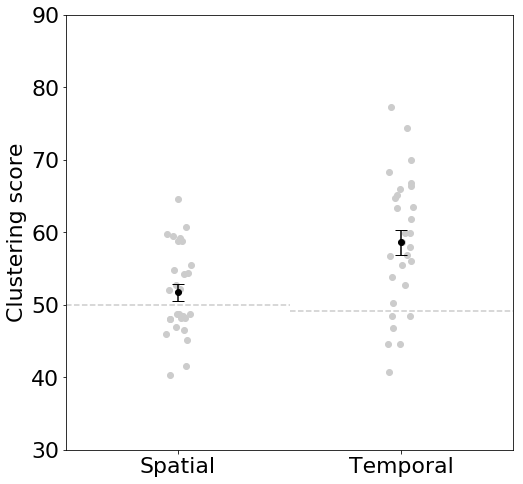

('r = ', -0.15226109698706447)
('p = ', 0.4304058041149349)


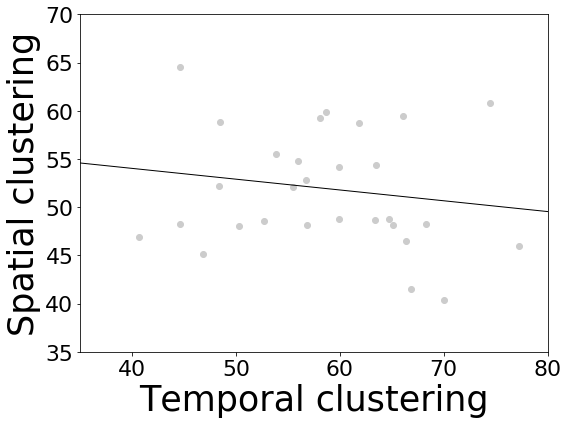

('mean p-rec', 0.49777342513078565)
('Primacy p-rec: ', 0.5130601753066256)
('Middle p-rec: ', 0.4348024702740727)
('Recency p-rec: ', 0.6086493984567006)
('Primacy effect: ', Ttest_relResult(statistic=2.0854488156103055, pvalue=0.04626232134588456))
('d', 0.38725812306568796)
('Recency effect: ', Ttest_relResult(statistic=5.519822031960542, pvalue=6.712201266707149e-06))
('d', 1.0250052189020544)


In [3]:
def plot_CS(subjects,stats = True):
    
    from effect_size import cohend

    aSCS = np.array([np.mean([i[0] for i in subi.SCS if i[1]<100])  for subi in subjects]) 
    aTCS = np.array([np.mean([i[0] for i in subi.TCS if i[1]<100]) for subi in subjects]) 
    
    if stats:
        thedata = [np.load('/scratch/nherweg/courier/01_ReactivatedSpatialContext/behavior/'+subi+'_permCS.npz') for subi in subjectList]
        
        # Calculate average permuted clustering scores over subjects
        pSCS = np.array([d['SCS'].tolist() for d in thedata]).mean(axis = 0)
        pTCS = np.array([d['TCS'].tolist() for d in thedata]).mean(axis = 0)
        
        # Calculate average actual clustering scores over subjects
        avg_pSCS = pSCS.mean(axis = 0)
        avg_pTCS = pTCS.mean(axis = 0)
        
        # Calculate p-values
        p_SCS = (100-scps.percentileofscore(pSCS,aSCS.mean(axis = 0)))/100.
        p_TCS = (100-scps.percentileofscore(pTCS,aTCS.mean(axis = 0)))/100.
        print('Spatial clustering score:', aSCS.mean(axis = 0),'p:',p_SCS)
        print('Temporal clustering score:',aTCS.mean(axis = 0),'p:',p_TCS)
    
    # Plot Clustering Scores
    fig1 = plt.figure(figsize = (8,8))
    ax1  = plt.subplot(111)
    ax1.scatter(np.concatenate([np.ones(aSCS.shape[0])+np.random.uniform(-0.06,0.06, size = aSCS.shape[0]),np.ones(aTCS.shape[0])+1+np.random.uniform(-0.06,0.06, size = aSCS.shape[0])]), np.concatenate([aSCS,aTCS]), color = [0.8,0.8,0.8])
    for ind,dat in enumerate([np.array(aSCS),np.array(aTCS)]):
        _,caps,_ = plt.errorbar(ind+1,np.mean(dat,axis = 0), yerr = np.std(dat,axis = 0,ddof = 1)/np.sqrt(len(dat)),color = 'k',capsize=6,fmt='o')
    ax1.set_xlim(0.5,2.5)
    ax1.tick_params(axis='x', labelsize=22)
    ax1.tick_params(axis='y', labelsize=22)
    ax1.set_ylabel('Clustering score', fontsize = 22)
    ax1.hlines(y = [avg_pSCS,avg_pTCS], xmin = [0.5,1.5], xmax = [1.5,2.5], linestyle = '--',color = [0.8,0.8,0.8])
    ax1.set_ylim(30,90)
    plt.xticks([1,2],['Spatial','Temporal'])
    plt.show()
    
    #fig1.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/behavioralClustering.eps')

    # Calculate correlation between spatial and temporal clustering
    slope,inter,r,p,_ = scps.stats.linregress(aTCS,y = aSCS)
    print('r = ',r)
    print('p = ',p)
    
    # Scatter plot
    fig2 = plt.figure(figsize = (8,6))
    ax2 = plt.subplot(111)
    ax2.scatter(aTCS,aSCS, c= [0.8,0.8,0.8])
    ax2.plot(np.concatenate([np.array([35]),np.array([80])],axis = 0),np.array(slope) * np.concatenate([np.array([30]),np.array([80])],axis = 0) + np.array(inter), '-', linewidth = 1, color = 'k')
    ax2.set_ylim(35,70)
    ax2.set_xlim(35,80)
    ax2.tick_params(axis='x', labelsize=22)
    ax2.tick_params(axis='y', labelsize=22)
    ax2.set_xlabel('Temporal clustering', fontsize = 35)
    ax2.set_ylabel('Spatial clustering', fontsize = 35)
    plt.tight_layout()
    plt.show()
    
    #fig2.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/behavioralClustering_regression.eps')

    # Calulate average probability of recall
    print('mean p-rec',np.mean([subi.p_rec for subi in subjects]))
    
    # Primacy
    p_rec_primacy = np.array([subi.events[(subi.events['type']=='WORD') & (subi.events['serialPos']<=3)]['recalled'].tolist().count(1)/float(len(subi.events[(subi.events['type']=='WORD') & (subi.events['serialPos']<=3)]['recalled'].tolist())) for subi in subjects])
    p_rec_middle  = np.array([subi.events[(subi.events['type']=='WORD') & (subi.events['serialPos']>3) & (subi.events['serialPos']<=9)]['recalled'].tolist().count(1)/float(len(subi.events[(subi.events['type']=='WORD') & (subi.events['serialPos']>3) & (subi.events['serialPos']<=9)]['recalled'].tolist())) for subi in subjects])
    p_rec_recency = np.array([subi.events[(subi.events['type']=='WORD') & (subi.events['serialPos']>9)]['recalled'].tolist().count(1)/float(len(subi.events[(subi.events['type']=='WORD') & (subi.events['serialPos']>9)]['recalled'].tolist())) for subi in subjects])

    print('Primacy p-rec: ',np.mean(p_rec_primacy))
    print('Middle p-rec: ',np.mean(p_rec_middle))
    print('Recency p-rec: ',np.mean(p_rec_recency))
    print('Primacy effect: ',scps.ttest_rel(p_rec_primacy,p_rec_middle))
    print('d',cohend(p_rec_primacy-p_rec_middle))
    print('Recency effect: ',scps.ttest_rel(p_rec_recency,p_rec_middle))
    print('d',cohend(p_rec_recency-p_rec_middle))
    
plot_CS(subjects,stats = True)


## Plot CRPs (Figure 1)

/home1/nherweg/01_toolbox/pybeh/pybeh/crp.py:102: RuntimeWarning: invalid value encountered in true_divide
  result[i, :] = actual / poss
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice


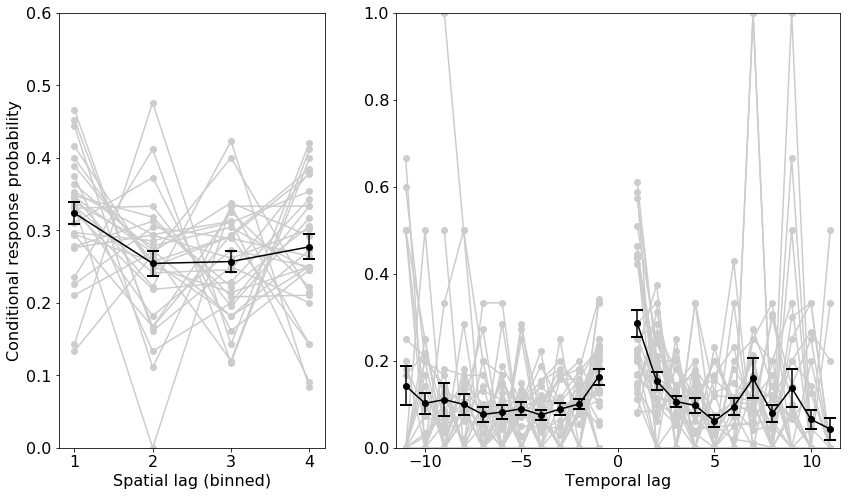

In [4]:
def plot_CRP(subjects):
    
    sys.path.append(path.abspath('/home1/nherweg/01_toolbox/pybeh'))
    from pybeh.crp import crp
    from matplotlib import gridspec
    
    # Calculate CRP
    pad_length = 20
    lag_num = 11
    bin_num = 4
    
    CRP_temporal = []
    for subi in subjects:
        recalls_ = []
        for sessi in subi.sessions:
            recs = sessi.events[(sessi.events['type']=='REC_WORD') & (sessi.events['serialPos'] > -999)]
            
            for ti in np.unique(recs['trial']):
                recalls_.append(recs[(recs['trial'] == ti)]['serialPos'].tolist()+np.zeros(pad_length-len(recs[(recs['trial'] == ti)]['serialPos'])).tolist())

        recalls_ = np.array(recalls_).astype(int)
        CRP_temporal.append(np.squeeze(crp(recalls = recalls_,subjects = np.array([subi.name] * recalls_.shape[0]),listLength = 12,lag_num = lag_num)))

    CRP_temporal = np.array(CRP_temporal)
    CRP_spatial = np.fliplr([subi.CRP for subi in subjects])
    
    # Plot CRPs
    fig1 = plt.figure(figsize = (14,8))
    gs = gridspec.GridSpec(1,2, width_ratios=[0.6,1])
    
    ax1 = plt.subplot(gs[0]) 
    for subi in subjects:
        ax1.plot(np.arange(bin_num,0,-1),subi.CRP, color = [0.8,0.8,0.8],zorder = 1)
        ax1.scatter(np.arange(bin_num,0,-1),subi.CRP, color = [0.8,0.8,0.8],zorder = 2) 
    _,caps,_ = plt.errorbar(np.arange(1,bin_num+1),CRP_spatial.mean(axis = 0), yerr = CRP_spatial.std(axis = 0,ddof = 1)/np.sqrt(CRP_spatial.shape[0]), color = 'k',fmt='o',capsize=6)
    ax1.plot(np.arange(1,bin_num+1),CRP_spatial.mean(axis = 0), color = 'k')
    for cap in caps:
        cap.set_markeredgewidth(2)
    ax1.set_ylim(0,.6)
    ax1.set_xlim(0.8,4.2)
    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.set_ylabel('Conditional response probability',fontsize = 16)
    ax1.set_xlabel('Spatial lag (binned)',fontsize = 16)
    
    ax2 = plt.subplot(gs[1])
    for sub_ind in range(len(subjects)):
        ax2.plot(np.arange(-lag_num,lag_num+1), CRP_temporal[sub_ind,:], color = [0.8,0.8,0.8],zorder = 1)
        ax2.scatter(np.arange(-lag_num,lag_num+1), CRP_temporal[sub_ind,:],color = [0.8,0.8,0.8],zorder = 2)
    _,caps,_ = plt.errorbar(np.arange(-lag_num,lag_num+1),np.nanmean(CRP_temporal,axis = 0), yerr = np.nanstd(CRP_temporal,axis = 0,ddof = 1)/np.sqrt(np.sum(np.isfinite(CRP_temporal),axis = 0)), color = 'k',fmt='o',capsize=6)
    ax2.plot(np.arange(-lag_num,lag_num+1),np.nanmean(CRP_temporal,axis = 0), color = 'k')
    for cap in caps:
        cap.set_markeredgewidth(2)
    ax2.set_ylim(0,1)
    ax2.set_xlim(-11.5,11.5)
    ax2.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    ax2.set_xlabel('Temporal lag',fontsize = 16)
    plt.show()
    
    #fig1.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/CRPs.eps')

plot_CRP(subjects)

## Clustering by number of trials

In [5]:
def clustering_by_time(subjects, var):

    import statsmodels.api as sm
    import pandas as pd
    from scipy import stats
    from statistics import lrtest
    
    df = pd.concat([pd.DataFrame.from_records(subi.events) for subi in subjects],ignore_index=True,sort = True)

    valid_recs = df[(df['type']=='REC_WORD') & (df['intrusion']==0) & (df['repeat']==0) & (df['singleRecall']==0) & (df[var]>-998)]
    valid_recs = valid_recs.groupby(['subject', 'session','trial'],as_index = False)[var].mean()
    valid_recs['session'] = valid_recs['session'].values.astype(int)
    cont_trial = np.concatenate([np.arange(len(valid_recs[valid_recs['subject'] == subi])) for subi in subjectList],axis = 0)
    valid_recs['cont_trial']=pd.Series(cont_trial,index = valid_recs.index)
    
    model = sm.MixedLM.from_formula(var+" ~ cont_trial ", groups="subject", data=valid_recs) 
    result = model.fit(reml = False, method = 'nm')
    llf_full = result.llf
    print(result.summary())
    
    model = sm.MixedLM.from_formula(var+" ~ 1 ", groups="subject", data=valid_recs) 
    result = model.fit(reml = False, method = 'nm')
    llf_reduced = result.llf
    
    lr, p = lrtest(llf_reduced, llf_full)
    print('Effect of trial','LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

print('Spatial clustering')
print('__________________')
clustering_by_time(subjects,'postPerc')
print('Temporal clustering')
print('__________________')
clustering_by_time(subjects,'postPerc_time')

Spatial clustering
__________________


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: postPerc  
No. Observations: 281     Method:             ML        
No. Groups:       29      Scale:              216.5342  
Min. group size:  2       Likelihood:         -1159.0193
Max. group size:  30      Converged:          Yes       
Mean group size:  9.7                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     50.670    1.434 35.342 0.000 47.860 53.480
cont_trial     0.122    0.166  0.738 0.460 -0.202  0.447
groups RE      9.237    0.636                           

('Effect of trial', 'LR test, p value: 0.55, 0.4566')
Temporal clustering
__________________
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: postPerc_time
No. Observations: 281     Method:             ML           
No. G

## Plot IRTs (Figure 1)

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


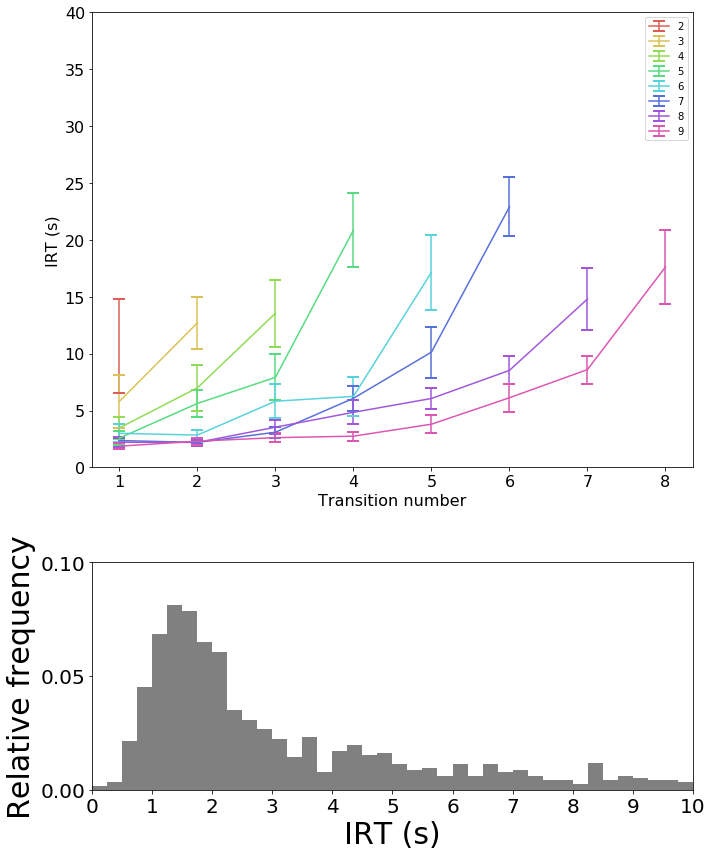

In [6]:
def plot_IRT(subjects):
    
    from matplotlib import gridspec
    import seaborn as sns

    fontsize = 16
    nmax = 8
    IRT = np.zeros((len(subjects),nmax,nmax))
    IRT[:] = np.nan
    
    IRT_pool = []
    for sind,subi in enumerate(subjects): 
  
        IRT_ = dict(zip(np.arange(1,nmax+1),[[] for i in range(nmax)]))

        for sessi in subi.sessions:      
            for ti in np.unique(sessi.events['trial']):

                irt_ = np.diff(sessi.events[(sessi.events['type']=='REC_WORD') & (sessi.events['intrusion'] == 0) & (sessi.events['repeat'] != 1)  & (sessi.events['trial'] == ti)]['rectime']/1000).tolist()    
                
                if len(irt_) > 0 and len(irt_) < nmax+1:
                    IRT_[len(irt_)].append(irt_)

        IRT_pool.extend(IRT_.values())
 
        for ind in np.arange(1,nmax+1):
            if len(IRT_[ind])>0:
                IRT[sind,:ind,ind-1] = np.mean(IRT_[ind],axis = 0)
    
    IRT_pool = [item for sublist in IRT_pool for item in sublist]
    IRT_pool = [item for sublist in IRT_pool for item in sublist]
    
    fig = plt.figure(figsize = (10,12))
    gs = gridspec.GridSpec(2,1, height_ratios=[2, 1])
    
    ax = plt.subplot(gs[0])
    ax.set_color_cycle(sns.color_palette("hls",8))
    for ind in np.arange(1,nmax+1): 
        _,caps,_ = ax.errorbar(np.arange(1,ind+1),np.nanmean(IRT[:,:ind,ind-1],axis = 0),np.nanstd(IRT[:,:ind,ind-1],axis = 0)/np.sqrt(np.sum(np.isfinite(IRT[:,0,ind-1]))),capsize=6)
        for cap in caps:
            cap.set_markeredgewidth(2)
    ax.set_ylim(0,40)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.set_ylabel('IRT (s)',fontsize = fontsize)
    ax.set_xlabel('Transition number',fontsize = fontsize)
    plt.legend([str(ind) for ind in np.arange(2,nmax+2)], loc = 1)
    
    ax = plt.subplot(gs[1])
    ax.hist(IRT_pool,bins = np.arange(0,90,0.25), color = [0.5,0.5,0.5], weights = [1./len(IRT_pool) for ii in IRT_pool], cumulative = False)
    plt.xlim(right = 10)
    plt.xlim(left = 0)
    plt.ylim((0,0.10))
    plt.xticks(np.arange(0,10+0.25,1))
    plt.yticks(np.arange(0,0.11,0.05))
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)
    plt.xlabel('IRT (s)', fontsize = 30)
    plt.ylabel('Relative frequency', fontsize = 30)
    plt.tight_layout()
    plt.show()

    #fig.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/IRT_by_transition.eps')
        
plot_IRT(subjects)

## Relation between SCS and IRT

In [7]:
def SCS_IRT(subjects, var):
    
    import pandas as pd
    import statsmodels.api as sm
    from statistics import lrtest
    
    irt = []
    scs = []
    sub = []
    perms = np.mean([np.mean(np.load('/scratch/nherweg/courier/01_ReactivatedSpatialContext/behavior/'+subi.name+'_permCS.npz')['SCS']) for subi in subjects])

    for subi in subjects:
        
        recs = subi.events[(subi.events['type'] == 'REC_WORD')]
        scs_ = recs[var][:-1]
        irt_ = recs['rectime'][1:]-recs['rectime'][:-1]
        irt_ = irt_[scs_>=0]
        scs_ = scs_[scs_>=0]
        
        irt.extend(irt_)
        scs.extend(scs_)
        sub.extend([subi.name for ii in irt_])

    d = {'IRT':irt,'SCS':scs,'sub':sub}
    df = pd.DataFrame(d)
    
    model = sm.MixedLM.from_formula('IRT ~ SCS ',groups = 'sub', data = df)
    result = model.fit(reml = False,method = 'nm')
    llf_full = result.llf
    print(result.summary())
    
    model = sm.MixedLM.from_formula('IRT ~ 1', groups="sub", data=df)
    result = model.fit(reml = False,method = 'nm')
    llf_IRT = result.llf

    lr, p = lrtest(llf_IRT, llf_full)
    print('Effect of clustering','LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

print('Spatial clustering')
print('__________________')
SCS_IRT(subjects, 'postPerc')
print('Temporal clustering')
print('__________________')
SCS_IRT(subjects, 'postPerc_time')

Spatial clustering
__________________
            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: IRT          
No. Observations:   1595    Method:             ML           
No. Groups:         29      Scale:              57072757.4768
Min. group size:    6       Likelihood:         -16527.8703  
Max. group size:    192     Converged:          Yes          
Mean group size:    55.0                                     
-------------------------------------------------------------
             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------
Intercept    6341.994  567.103 11.183 0.000 5230.494 7453.495
SCS           -12.227    5.673 -2.155 0.031  -23.346   -1.109
groups RE 4895328.882  244.443                               

('Effect of clustering', 'LR test, p value: 4.64, 0.0313')
Temporal clustering
__________________
            Mixed Linear Model Regression Results
Model:             

## Correlation between temporal and spatial proximity during encoding

In [8]:
def corr_spat_temp(subjects):
    
    r = []
    
    for subi in subjects:
    
        spat_prox = []
        temp_prox = []
        for sessi in subi.sessions:
            for ti in np.unique(sessi.events[sessi.events['type']=='WORD']['trial']):

                temp_prox_ = []
                for w_ind in range(len(sessi.events[(sessi.events['type']=='WORD') & (sessi.events['trial']==ti)])-1):
                    temp_prox_.extend(-abs(sessi.events[(sessi.events['type']=='WORD') & (sessi.events['trial']==ti)]['mstime'][w_ind+1:]-sessi.events[(sessi.events['type']=='WORD') & (sessi.events['trial']==ti)]['mstime'][w_ind]))
                temp_prox.extend(np.array([scps.percentileofscore(temp_prox_,wi) for wi in temp_prox_]))

                spat_prox_ = subi.get_dist_mat(method = 'percentile', k = 1, inc = sessi.events[(sessi.events['type']=='WORD') & (sessi.events['trial']==ti)]['store'])
                spat_prox.extend(spat_prox_[spat_prox_>0])

        r.append(scps.pearsonr(temp_prox,spat_prox)[0])
    print('MEAN: ',np.mean(r))
    print('MAX: ',np.max(r))
    print('MIN: ',np.min(r))
corr_spat_temp(subjects)

('MEAN: ', -0.012175129808760182)
('MAX: ', 0.31144594118909225)
('MIN: ', -0.16882023449187625)


## Plot electrode locations (Figure 2)

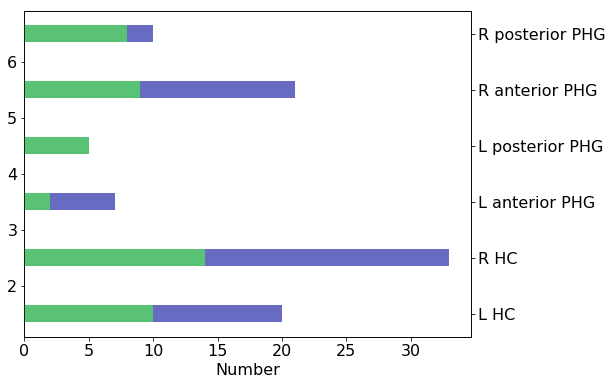

In [9]:
def plot_electrodes(subjects):

    HC_MNI         = []
    HC_labels      = []
    HC_sub_labels  = []
    PHG_MNI        = []
    PHG_labels     = []
    PHG_sub_labels = []

    for subi in subjects:

        subi = subi.get_channel_info().define_rois()

        HC_inds = [i_ind for i_ind,ii in enumerate(subi.bpPairs) if tuple((ii[0],ii[1])) in subi.roi['HC']]
        PHG_inds = [i_ind for i_ind,ii in enumerate(subi.bpPairs) if tuple((ii[0],ii[1])) in subi.roi['PHG']]
        HC_MNI.extend(subi.bpMNI[HC_inds,:].tolist())
        HC_labels.extend(subi.bpLabel[HC_inds].tolist())
        HC_sub_labels.extend(np.unique(subi.bpLabel[HC_inds]).tolist())

        PHG_MNI.extend(subi.bpMNI[PHG_inds,:].tolist())
        PHG_l = subi.bpLabel[PHG_inds].tolist()
        PHG_l = ['Left Parahippocampal Gyrus, posterior division'  if li == 'Parahippocampal Gyrus, posterior division' and subi.bpMNI[PHG_inds,:][l_ind,0] < 0 else li for l_ind,li in enumerate(PHG_l)]
        PHG_l = ['Right Parahippocampal Gyrus, posterior division'  if li == 'Parahippocampal Gyrus, posterior division' and subi.bpMNI[PHG_inds,:][l_ind,0] >= 0 else li for l_ind,li in enumerate(PHG_l)]
        PHG_l = ['Left Parahippocampal Gyrus, anterior division'  if li == 'Parahippocampal Gyrus, anterior division' and subi.bpMNI[PHG_inds,:][l_ind,0] < 0 else li for l_ind,li in enumerate(PHG_l)]
        PHG_l = ['Right Parahippocampal Gyrus, anterior division'  if li == 'Parahippocampal Gyrus, anterior division' and subi.bpMNI[PHG_inds,:][l_ind,0] >= 0 else li for l_ind,li in enumerate(PHG_l)]
        PHG_labels.extend(PHG_l)
        PHG_sub_labels.extend(np.unique(PHG_l).tolist())

    labels = PHG_labels + HC_labels
    sub_labels = HC_sub_labels+PHG_sub_labels

    mapper = {'Left Hippocampus':1, 'Right Hippocampus':2, 'Left Parahippocampal Gyrus, anterior division':3,'Left Parahippocampal Gyrus, posterior division':4, 'Right Parahippocampal Gyrus, anterior division':5,'Right Parahippocampal Gyrus, posterior division':6}
    labels = [mapper[li] for li in labels]

    sub_labels = [mapper[li] for li in sub_labels]

    fig = plt.figure(figsize = (8,6))
    ax = plt.subplot(111)
    ax.hist(labels,bins = [1,2,3,4,5,6,7],color = [103/255.,107/255.,193/255.],orientation = 'horizontal',rwidth = 0.3)#blue
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlabel('Number',fontsize = 16)
    
    ax2 = ax.twinx()
    ax2.hist(sub_labels,bins = [1,2,3,4,5,6,7],color = [89/255.,194/255.,117/255.],orientation = 'horizontal',rwidth = 0.3)#green

    ax2.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    ax2.set_yticks(np.arange(1.5,7))
    ax2.set_yticklabels(['L HC','R HC','L anterior PHG','L posterior PHG','R anterior PHG','R posterior PHG'])#,rotation = 45)
    plt.show()

    #fig.savefig('/home1/nherweg/projects/DP3/analyses/figures/electrodes_by_region.eps')

    #np.save('/home1/nherweg/projects/DP3/ReactivatedSpatialContext_elecsHC.npy',np.array(HC_MNI))
    #np.save('/home1/nherweg/projects/DP3/ReactivatedSpatialContext_elecsPHG.npy',np.array(PHG_MNI))
    
plot_electrodes(subjects)

## Wavelet convolution

In [ ]:
def mwf(varin,subjectList = subjectList,sessionList = sessionList,exclude = False): 
    
    from ptsa.data.filters import MorletWaveletFilter
    from ptsa.data.readers import EEGReader
    from ptsa.data.filters import MonopolarToBipolarMapper
    from ptsa.data.filters     import ButterworthFilter
    from ptsa.data.timeseries import TimeSeries
    import numpy as np
    from os                    import path,listdir                 
    import sys
    sys.path.append(path.abspath('/home1/nherweg/00_projects/courier/02_scripts'))
    sys.path.append(path.abspath('/home1/nherweg/01_toolbox/brPY'))
    from subject               import subject
    from session               import session
    from brpylib               import NsxFile
    from copy import deepcopy
    import scipy as scps
    
    # Get data
    sessi = session(varin[0],False,sessionList).get_events(exc = 'micro', processed = False).calc_transition_dist(True)
    outp  = varin[1]
    subi  = subject(name = sessi.subj,subjectList = subjectList).concatenate(False,sessionList,processed = True).get_channel_info()
    
    # Filter events without eeg
    sessi.events = sessi.events[(sessi.events['eegfile'] != '[]') & (sessi.events['eegfile'] != '') & (sessi.events['eegfile'] != '-999')]
    subi.events = subi.events[(subi.events['eegfile'] != '[]') & (subi.events['eegfile'] != '') & (subi.events['eegfile'] != '-999')]

    # Check if analyses is already complete
    if not path.isfile('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+'_sess'+str(str(sessi.snumber))+'_POW'+outp):
        
        # Read EEG data 
        buffer_time = 2.0
        if 'RET' not in outp:
            start_time = 0.1
            data_time  = 0.4
            theevents  = sessi.events[(sessi.events.type == 'WORD') ]
        else:
            start_time = -0.75
            data_time  = 0.75
            theevents  = sessi.events[(sessi.events.type == 'REC_WORD') & (sessi.events.intrusion == 0) & (sessi.events['repeat'] != 1) ]
 
        EEG = EEGReader(events = theevents,channels=subi.mpChans, start_time=start_time, end_time=start_time+data_time, buffer_time=buffer_time).read()
        
        # Reref
        EEG = MonopolarToBipolarMapper(timeseries=EEG, bipolar_pairs=subi.bpPairs).filter() 

        # Downsample if necessary
        if EEG.samplerate > 400:
            EEG = EEG.resampled(400)
   
        # Fix time axis
        if len(EEG['time']) != int(data_time*EEG.samplerate.data)+int(buffer_time*2*EEG.samplerate.data)-1:
            EEG = EEG[:,:,:-1]
        EEG['time'] = np.arange(start_time-buffer_time,start_time+data_time+buffer_time,1/EEG['samplerate'].data)[:-1]

        # Notch filter 
        EEG = ButterworthFilter(timeseries=EEG, freq_range=subi.linefreq, filt_type='stop', order=4).filter()

        # Identify and exclude outliers
        EEG_mc   = EEG - np.broadcast_to(EEG.mean(axis = 2).data[:,:,np.newaxis],EEG.shape)
        q75, q25 = np.percentile(EEG_mc.data.reshape(EEG_mc.data.shape[0],-1), [75 ,25],axis = 1)
        IQR      = q75 - q25
        out_p    = np.any(EEG_mc > (q75+5.*IQR)[:,np.newaxis,np.newaxis],2)
        out_n    = np.any(EEG_mc < (q25-5.*IQR)[:,np.newaxis,np.newaxis],2)
        out      = np.any(np.array([out_p,out_n]),axis=0) 
        del(out_p,out_n,q75,q25,IQR,EEG_mc)
        EEG.data[np.broadcast_to(out[:,:,np.newaxis],EEG.data.shape)] = float('nan')
        f = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/artifact_correction.txt','a+')
        f.write(sessi.subj+'_'+str(sessi.snumber)+': '+str((out[out].shape[0]/np.float(out.shape[0]*out.shape[1]))*100.)+'% excluded\n')
        f.close()
        
        if 'RET' in outp:
            EEG.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/PHS/'+subi.name+'_sess'+str(sessi.snumber)+'_RAW'+outp)
        
        f2use = np.logspace(np.log10(3), np.log10(100), 25)
        
        # Do covolution, remove buffer, log transform, downsample
        print f2use
    
        # Some events have nan's so we are doing this separately to avoid concat error
        POW  = MorletWaveletFilter(timeseries=EEG,
                                 freqs= f2use,
                                 output='power', width = 5                   
                                 ).filter()
        PHS  = MorletWaveletFilter(timeseries=EEG,
                                 freqs= f2use,
                                 output='phase', width = 5                   
                                 ).filter()
        
        del(EEG)
        
        if 'RET' in outp:
            PHS = PHS.remove_buffer(duration = buffer_time)
            PHS.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/PHS/'+subi.name+'_sess'+str(sessi.snumber)+'_PHS'+outp)

        del(PHS)

        POW = np.log10(POW)
        
        if 'RET' in outp:
            POW.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+'_sess'+str(sessi.snumber)+'_POW_withBuffer'+outp)
        
        POW = POW.remove_buffer(duration=buffer_time)
        POW.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+'_sess'+str(sessi.snumber)+'_POW'+outp)
        
    print('done'+sessi.path)

with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(sessionList), cores_per_job=1) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(mwf, [[sessionList.index(sessi),outi] for sessi,outi in zip(sessionList,['_RET' for sessi in sessionList])])    #

with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(sessionList), cores_per_job=1) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(mwf, [[sessionList.index(sessi),outi] for sessi,outi in zip(sessionList,['' for sessi in sessionList])])

## Amount of data removed by artifact rejection

In [10]:
art = []
with open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/artifact_correction.txt', 'r') as in_file:
     for line in in_file:
  
        if line not in art:
            art.append(line)
        else:
            print(line)

print('MAX ', np.max([np.float(ai.split(' ')[1].split('%')[0]) for ai in art]))
print('MIN ', np.min([np.float(ai.split(' ')[1].split('%')[0]) for ai in art]))
print('MEAN ',np.mean([np.float(ai.split(' ')[1].split('%')[0]) for ai in art]))

('MAX ', 10.9903381643)
('MIN ', 0.0)
('MEAN ', 2.4983425223397053)


## Average power over time

In [ ]:
def t_average(varin,sessionList = sessionList, freqs = freqs):
    
    # Import tools
    import numpy as np
    from ptsa.data.timeseries import TimeSeries
    from os import path
    import sys
    sys.path.append(path.abspath('/home1/nherweg/00_projects/courier/02_scripts'))
    from session import session

    sessi = session(varin[0],True,sessionList).get_events()
    outp = varin[1]
    
    if not path.isfile('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt'):
        f = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt','w')
        f.write('')
        f.close()
    
    exc = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt','r').read().split('\n')

    # Check if analyses is already complete
    if not path.isfile('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+outp) and sessi.subj+'_sess'+str(sessi.snumber)+outp not in exc:
        
        # Load data
        if 'RET' not in outp:
            POW = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+'_POW')
        else:
            POW = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+'_POW_RET')

        #Z-score
        sessM   = np.nanmean(np.reshape(POW.data,(POW.data.shape[0],POW.data.shape[1],-1)),axis = -1)
        sessSTD = np.nanstd(np.reshape(POW.data,(POW.data.shape[0],POW.data.shape[1],-1)),axis = -1, ddof = 1)

        POW = POW-np.broadcast_to(sessM[:,:,np.newaxis,np.newaxis], POW.shape)
        POW = POW/np.broadcast_to(sessSTD[:,:,np.newaxis,np.newaxis], POW.shape)

        # Average over time
        POW_t = POW.mean(skipna=True,dim='time')

        # Save to disk
        POW_t.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+outp)

        # Remove channels with less than nmin+1 trials per cond and save out sessions with no channels left
        nmin = 7

        ntrials = []
        for ind in range(len(POW_t[chans])):
            ntrials.append(len(POW_t[0,ind,~np.isnan(POW_t[0,ind,:].data)]))
        inc = np.array(ntrials) > nmin
        POW_t = POW_t[:,inc,:]
        
        if POW_t.shape[1] == 0:    
            f = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt','a')
            f.write(sessi.subj+'_sess'+str(sessi.snumber)+outp+'\n')
            f.close()

with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(sessionList), cores_per_job=1, extra_params={'mem':30}) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(t_average,[[sessionList.index(sessi),outi] for sessi,outi in zip(sessionList,['_POW_RET_TAVG' for sessi in sessionList])])    

## Average power over time and frequency band

In [ ]:
def tf_average(varin,sessionList = sessionList, freqs = freqs):
    
    # Import tools
    import numpy as np
    from ptsa.data.timeseries import TimeSeries
    from os import path
    import sys
    sys.path.append(path.abspath('/home1/nherweg/00_projects/courier/02_scripts'))
    from session import session

    sessi = session(varin[0],True,sessionList).get_events()
    outp = varin[1]
    
    if not path.isfile('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt'):
        f = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt','w')
        f.write('')
        f.close()
    
    exc = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt','r').read().split('\n')

    # Check if analyses is already complete
    if not path.isfile('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+outp) and sessi.subj+'_sess'+str(sessi.snumber)+outp not in exc:
        
        # Load data
        if 'RET' not in outp:
            POW = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+'_POW')
        else:
            POW = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+'_POW_RET')

        #Z-score
        sessM   = np.nanmean(np.reshape(POW.data,(POW.data.shape[0],POW.data.shape[1],-1)),axis = -1)
        sessSTD = np.nanstd(np.reshape(POW.data,(POW.data.shape[0],POW.data.shape[1],-1)),axis = -1, ddof = 1)

        POW = POW-np.broadcast_to(sessM[:,:,np.newaxis,np.newaxis], POW.shape)
        POW = POW/np.broadcast_to(sessSTD[:,:,np.newaxis,np.newaxis], POW.shape)

        # Average over time
        if 'RET' not in outp:
            raise ValueError('Adapt time window.')
        POW_t = POW.mean(skipna=True,dim='time')

        chans = 'channels'

        # ...over frequency
        POW_tf = TimeSeries(np.zeros((len(freqs),len(POW_t[chans]),len(POW_t['events']))), 
                                dims=['frequency',chans,'events'], 
                                coords={'frequency':sorted(freqs, key=freqs.get), chans: POW_t[chans],'events':POW_t['events'],'samplerate':POW_t['samplerate'] })
        
        for f_ind,freqi,freqk in zip(range(len(freqs)),sorted(freqs.values()),sorted(freqs, key=freqs.get)):
            POW_tf[POW_tf.frequency == freqk] = POW_t[(POW_t.frequency>=freqi[0]) & (POW_t.frequency<freqi[1]),:,:].mean(skipna=True,dim='frequency').data[np.newaxis,:,:]

        # Save to disk
        POW_tf.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+outp)
        del (POW_tf)
        
        # Remove channels with less than nmin+1 trials per cond and save out sessions with no channels left
        nmin = 7

        ntrials = []
        for ind in range(len(POW_t[chans])):
            ntrials.append(len(POW_t[0,ind,~np.isnan(POW_t[0,ind,:].data)]))
        inc = np.array(ntrials) > nmin
        POW_t = POW_t[:,inc,:]
        
        if POW_t.shape[1] == 0:    
            f = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt','a')
            f.write(sessi.subj+'_sess'+str(sessi.snumber)+outp+'\n')
            f.close()

with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(sessionList), cores_per_job=1, extra_params={'mem':30}) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(tf_average,[[sessionList.index(sessi),outi] for sessi,outi in zip(sessionList,['_POW_RET_AVG' for sessi in sessionList])])    

## Average power over ROI

In [ ]:
def r_average(varin, subjectList = subjectList, sessionList = sessionList):
    
    # Import tools
    import numpy as np
    from ptsa.data.timeseries import TimeSeries
    from os import path
    import sys
    sys.path.append(path.abspath('/home1/nherweg/00_projects/courier/02_scripts'))
    from subject import subject 
    
    subi  = subject(index = varin[0],subjectList = subjectList).concatenate(False,sessionList).get_channel_info().define_rois()
    outp = varin[1]
    exc = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt','r').read().split('\n')
    
    if 'RET' not in outp:
        inp = '_POW_AVG'
    elif 'TAVG' in outp:
        inp = '_POW_RET_TAVG'
    else:
        inp = '_POW_RET_AVG'
        
    sessions2use = [si for si in subi.spath if subi.name + '_sess' + si.split('/')[-1][-5] + inp not in exc]

    if len(sessions2use) > 0:
    
        if not path.isfile('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+outp):

            # Concatenate
            POW = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+'_'+sessions2use[0][sessions2use[0].find('sess'):sessions2use[0].find('sess')+5]+inp)
            print POW.events.dtype
            for sessi in sessions2use[1:]:
                print TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+'_'+sessi[sessi.find('sess'):sessi.find('sess')+5]+inp).events.dtype
                POW = POW.append(TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+'_'+sessi[sessi.find('sess'):sessi.find('sess')+5]+inp),dim = 'events')
            
            chans = 'channels'
            
            # Average over ROI
            POW_tfr = TimeSeries(np.zeros((len(POW['frequency']),len(subi.roi),len(POW['events']))), 
                                   dims=['frequency','roi','events'], 
                                   coords={'frequency':POW['frequency'], 'roi': sorted(subi.roi),'events':POW['events'],'samplerate':POW['samplerate']})

            for a_ind, areak in zip(range(len(subi.roi)),sorted(subi.roi)):
                areai = subi.roi[areak]
                chanindc = [ind for ind, channeli in enumerate(POW.coords[chans]) if channeli.item() in areai]
                if len(chanindc) == 0:
                    POW_tfr[:,POW_tfr['roi'] == areak,:] = float('nan')
                else:
                    POW_tfr[:,POW_tfr['roi'] == areak,:] = POW[:,np.array(chanindc),:].mean(skipna=True,dim=chans).data[:,np.newaxis,:]

            # Save to disk
            POW_tfr.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+outp)
    elif subi.name+outp not in exc: 
        f = open('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/Trialcount_exc.txt','a')
        f.write(subi.name+outp+'\n')
        f.close()

with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(subjectList), cores_per_job=1, extra_params={'mem':20}) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(r_average, [[ind,outi] for ind,outi in zip(range(len(subjectList)),['_POW_RET_TAVGcorr' for sessi in sessionList])])

## Correlation between power and clustering (Figure 3a-b)

In [11]:
# Correlation within subjects
def correlate_dist(dist,inp,subjectList = subjectList):
    
    from statsmodels.regression import linear_model as sm

    for ind,subi in enumerate(subjectList):
        
        POW_ = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi+inp)

        if ind == 0:
            params = TimeSeries(np.zeros((len(subjectList),len(POW_['frequency']),len(POW_['roi']),5)), dims=['subject','frequency','roi','predictor'], 
                             coords={'subject': subjectList,'frequency':POW_['frequency'], 'roi': POW_['roi'],'predictor': ['constant','spatialDist','temporalDist','outputPosition','serialPosition'], 'samplerate':1})
            params.data[:]  = float('nan')
    
        for freqi in params.coords['frequency'].values:
            for areai in params.coords['roi'].values:
                
                thedata = []
                if areai in POW_['roi'].data:
                    
                    thedata.append(POW_[(POW_['frequency'] == freqi),(POW_['roi'] == areai),:].data.flatten('C'))
                    thedata.append(POW_['events'].data.view(np.recarray)[dist])
                    thedata.append(POW_['events'].data.view(np.recarray)[dist+'_time'])
                    thedata.append(POW_['events'].data.view(np.recarray)['outputPosition'])
                    thedata.append(POW_['events'].data.view(np.recarray)['serialPos'])
                    
                    filt = np.all([~np.isnan(dat) for dat in thedata], axis = 0)
                    thedata = [dat[filt] for dat in thedata]
                    
                    if len(thedata[0])>7: # Exclude based on events
                        
                        y = np.array(thedata[0])
                        X = np.transpose(thedata[1:])
                        X = sm.add_constant(X)
                  
                        model = sm.OLS(y,X)
                        results = model.fit()
                            
                        params[(params['subject'] == subi),(params['frequency'] == freqi),(params['roi'] == areai),:] =  results.params
                    else: 
                        params[(params['subject'] == subi),(params['frequency'] == freqi),(params['roi'] == areai),:] = float('nan')      
                else: 
                    params[(params['subject'] == subi),(params['frequency'] == freqi),(params['roi'] == areai),:] = float('nan')

    params.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/beta'+inp+'_'+dist)

# Correlation for frequency bands
correlate_dist('postPerc','_POW_RET_AVGcorr') 
# Correlation for each frequency step
correlate_dist('postPerc','_POW_RET_TAVGcorr') 

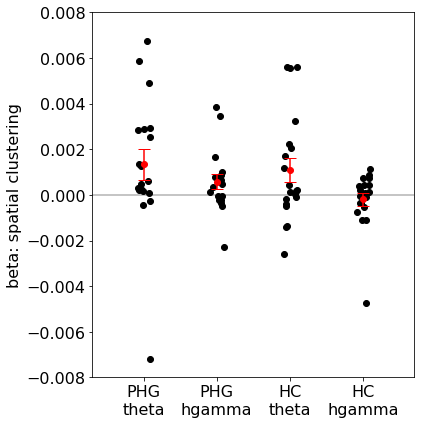

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    params  
No. Observations:     78         Method:                ML      
No. Groups:           25         Scale:                 0.0000  
Min. group size:      2          Likelihood:            372.3854
Max. group size:      4          Converged:             Yes     
Mean group size:      3.1                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.000    0.000 -0.207 0.836 -0.001  0.001
C(frequency)[T.theta]  0.001    0.000  2.263 0.024  0.000  0.002
C(area)[T.PHG]         0.001    0.000  1.132 0.258 -0.000  0.001
groups RE              0.000    0.000                           

frequency
LR test, p value: 4.91, 0.0267
area
LR test, p value: 1.27, 0.2596
frequency x area
LR test,

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [16]:
def correlation_group_stats_plot():
    
    import pandas as pd
    import statsmodels.api as sm
    from effect_size import cohend
    from statistics import lrtest
    
    col = [(.56,.24,.24),(0.8,0.3,0.3),(0.48,.3,0.53),(0.8,0.4,0.9)]

    areas_fig = ['PHG','PHG','HC','HC']
    freqs_fig = ['theta','hgamma','theta','hgamma']
    
    # Get data
    params     = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/beta_POW_RET_AVGcorr_postPerc')
    subs       = np.array([[subi]*len(params['frequency'])*len(params['roi']) for subi in params['subject'].data]).flatten()
    frequency  = np.array([[[ii]*len(params['roi'].data) for ii in  params['frequency'].data] for subi in subjects]).flatten()
    area       = np.array([params['roi'].data.tolist()*len(params['frequency'].data) for subi in subjectList]).flatten() 
    
    d = {'params': params[:,:,:,1].data.reshape(-1),'params_time':params[:,:,:,2].data.reshape(-1), 'subs':subs,'frequency':frequency,'area':area}
    df = pd.DataFrame(data = d)
    df = df[(np.isfinite(df['params']))]
    for ii in params['roi']:
        if ii not in areas_fig:
            df = df[df['area']!=ii]
    for ii in params['frequency']:
        if ii not in freqs_fig:
            df = df[df['frequency']!=ii]
            
    # Plot data
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    for index,freq,area in zip(range(len(freqs_fig)),freqs_fig,areas_fig):
        plt.scatter(np.ones(len(df[(df['frequency']==freq) & (df['area'] == area)]))*(index+1)+np.random.uniform(-0.1,0.1, size = len(df[(df['frequency']==freq) & (df['area'] == area)])), df[(df['frequency']==freq) & (df['area'] == area)]['params'], c = 'k',zorder = 2)
    ax.set_ylim([-0.008,0.008])
    ax.set_xlim([0.3,+len(freqs_fig)+0.7])
    ax.set_ylabel('beta: spatial clustering',fontsize = 16)
    ax.axhline(y =0, c= [0.7,0.7,0.7],zorder = 1)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.xticks(range(1,len(areas_fig)+1), [areai+'\n'+freqi for areai,freqi in zip(areas_fig,freqs_fig)])
    for index,freq,area in zip(range(len(freqs_fig)),freqs_fig,areas_fig):
        _,caps,_ = plt.errorbar(index+1,np.mean(df[(df['frequency']==freq) & (df['area'] == area)]['params'],axis = 0), yerr = np.std(df[(df['frequency']==freq) & (df['area'] == area)]['params'],axis = 0,ddof = 1)/np.sqrt(len(df[(df['frequency']==freq) & (df['area'] == area)]['params'])),ecolor = 'r',color = 'r',capsize=6,fmt='o')
    plt.tight_layout()
    plt.show()
    
    #fig.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/corr_power_clustering.eps')
    
    # Do stats
    model = sm.MixedLM.from_formula('params ~ C(frequency) + C(area)',groups = 'subs', data = df)
    result = model.fit(reml = False,method = 'nm')
    llf_full = result.llf
    print(result.summary())

    model = sm.MixedLM.from_formula('params ~ C(area) ', groups="subs", data=df)
    result = model.fit(reml = False,method = 'nm')
    llf_frequency = result.llf

    model = sm.MixedLM.from_formula('params ~ C(frequency)', groups="subs", data=df)
    result = model.fit(reml = False,method = 'nm')
    llf_area = result.llf

    model = sm.MixedLM.from_formula('params ~ C(frequency) + C(area)  +C(frequency) * C(area)', groups="subs", data=df)
    result = model.fit(reml = False,method = 'nm')
    llf_inter_freqarea = result.llf

    print('frequency')
    lr, p = lrtest(llf_frequency, llf_full)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

    print('area')
    lr, p = lrtest(llf_area, llf_full)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

    print('frequency x area')
    lr, p = lrtest(llf_full, llf_inter_freqarea)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

    # Average gammer power over brain region
    df_g = df[(df['frequency'] == 'hgamma')]
    df_g = df_g.groupby(['subs'],as_index = False).mean()

    print('Average gamma effect vs. 0')
    print(scps.ttest_1samp(df_g['params'].values,0))
    print('cohend',cohend(df_g['params'].values))

    # Average theta power over brain region
    df = df[(df['frequency'] == 'theta')]
    df = df.groupby(['subs'],as_index = False).mean()

    print('Average theta effect vs. 0')
    print(scps.ttest_1samp(df['params'].values,0))
    print('cohend',cohend(df['params'].values))

    # Average theta effect for space vs. time 
    print('Average theta effect for time')
    print(scps.ttest_1samp(df['params_time'].values,0))
    print('cohend',cohend(df['params_time'].values))

    print('Average theta effect for space vs. time')
    print(scps.ttest_rel(df['params'].values,df['params_time'].values))
    print('cohend',cohend(df['params'].values-df['params_time'].values))
    
correlation_group_stats_plot()

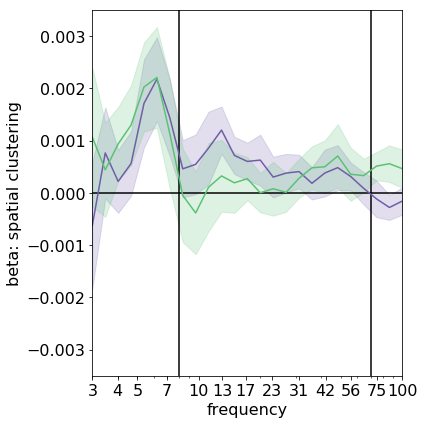

In [17]:
def correlation_group_stats_plot_all_freq():
    
    from matplotlib.ticker import ScalarFormatter

    col_PHG = [89/255.,194/255.,117/255.]
    col_HC = [110/255.,94/255.,166/255.]
    
    areas_fig = ['PHG','HC']
     
    # Get data
    params = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/beta_POW_RET_TAVGcorr_postPerc')
    params = params[:,:,(params['roi'] == 'HC') | (params['roi'] == 'PHG'),1]
  
    # Plot data
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    for index,area in zip(range(len(params['roi'])),params['roi']):
        if area == 'HC':
            col = col_HC
        else: col = col_PHG
        ax.plot(params['frequency'], np.nanmean(params[:,:,index],axis = 0), c = col,zorder = 2)
        ax.fill_between(params['frequency'], np.nanmean(params[:,:,index],axis = 0)-np.nanstd(params[:,:,index],axis = 0)/np.sqrt(np.sum(np.isfinite(params[:,:,index]),axis = 0)),np.nanmean(params[:,:,index],axis = 0)+np.nanstd(params[:,:,index],axis = 0)/np.sqrt(np.sum(np.isfinite(params[:,:,index]),axis = 0)), color = col, alpha =0.2)
    ax.set_ylim([-0.0035,0.0035])   
    ax.set_xlim([3,100]) 
    ax.set_xscale('log')
    ax.set_xticks(np.round(params['frequency'])[::2])
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.axhline(y = 0, c= 'k',zorder = 1)
    ax.axvline(x = 8, c= 'k',zorder = 1)
    ax.axvline(x = 70, c= 'k',zorder = 1)
    ax.set_xlabel('frequency',fontsize = 16)
    ax.set_ylabel('beta: spatial clustering', fontsize = 16)
    plt.tight_layout()
    plt.show()
   
    #fig.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/corr_power_by_freq.eps')

correlation_group_stats_plot_all_freq()

## Time frequency plots (Figure 3c)

In [ ]:
def data2plot(varin,subjectList = subjectList,sessionList = sessionList):

    from ptsa.data.timeseries import TimeSeries
    import numpy as np
    from os                    import path                 
    import sys
    sys.path.append(path.abspath('/home1/nherweg/00_projects/courier/02_scripts'))
    from subject               import subject
    from session               import session
    
    sessi = session(sessionList.index(varin),True,sessionList).get_events()
    subi =  subject(name = sessi.subj,subjectList = subjectList).concatenate(False,sessionList).get_channel_info().define_rois()
    POW = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+'_POW_withBuffer_RET')
    
    # Average over ROI
    POW_tfr = TimeSeries(np.zeros((len(POW['frequency']),len(subi.roi),len(POW['events']),len(POW['time']))), 
                           dims=['frequency','roi','events','time'], 
                           coords={'frequency':POW['frequency'], 'roi': sorted(subi.roi),'events':POW['events'],'time':POW['time'],'samplerate':POW['samplerate']})

    for a_ind, areak in zip(range(len(subi.roi)),sorted(subi.roi)):
        areai = subi.roi[areak]
        chanindc = [ind for ind, channeli in enumerate(POW.coords['channels']) if channeli.item() in areai]
        if len(chanindc) == 0:
            POW_tfr[:,POW_tfr['roi'] == areak,:] = float('nan')
        else:
            POW_tfr[:,POW_tfr['roi'] == areak,:] = POW[:,np.array(chanindc),:,:].mean(skipna=True,dim='channels').data[:,np.newaxis,:,:]

    POW_tfr = POW_tfr[:,(POW_tfr['roi']=='HC') | (POW_tfr['roi']=='PHG'),:,:]
    
    POW_tfr.to_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+sessi.subj+'_sess'+str(sessi.snumber)+'_POW_withBuffer_RET'+'_2plot_alltrials')
    
with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=20, cores_per_job=1, extra_params={'mem':45}) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(data2plot, sessionList)    

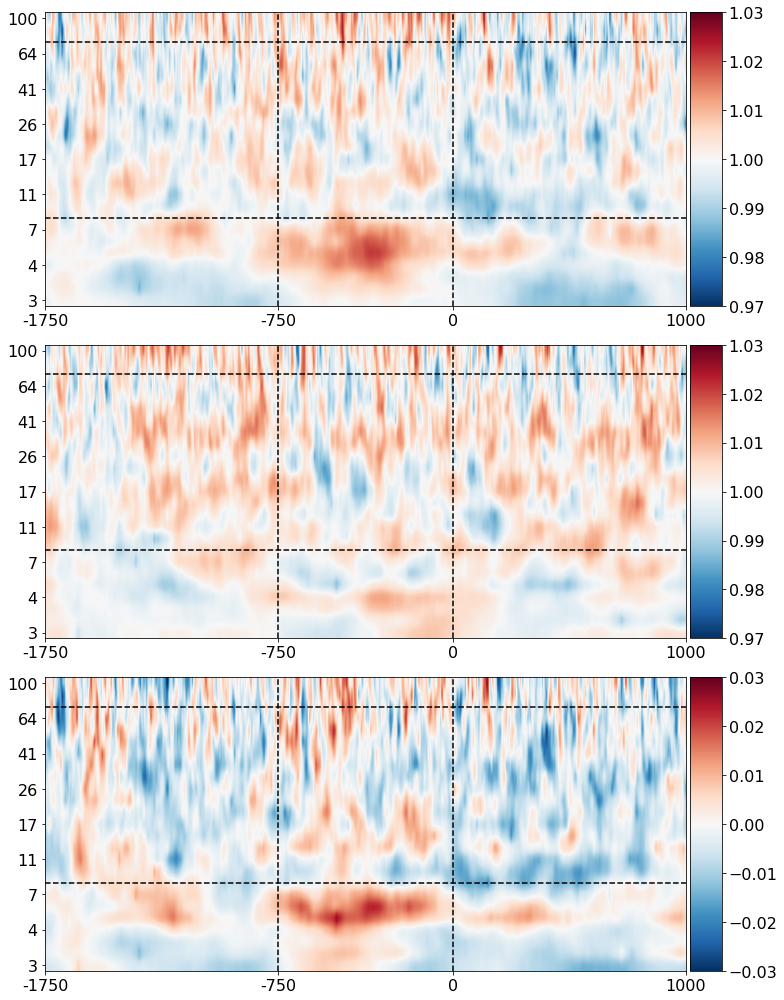

In [14]:
def make_tf_plot(subjects):
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    POW    = []
    C_POW  = []
    NC_POW = []
    N    = []
    N_C  = []
    N_NC = []
    
    for subi in subjects:
        for s_ind,si in enumerate(subi.sessions):
            if s_ind == 0:
                all_pow = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+'_sess'+str(si.snumber)+'_POW_withBuffer_RET'+'_2plot_alltrials').remove_buffer(duration=1.)
                c_pow   = all_pow[:,:,all_pow['events'].data['postPerc']>70,:]
                nc_pow  = all_pow[:,:,all_pow['events'].data['postPerc']<30,:]
            else:
                all_pow_ = TimeSeries.from_hdf('/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'+subi.name+'_sess'+str(si.snumber)+'_POW_withBuffer_RET'+'_2plot_alltrials').remove_buffer(duration=1.)
                all_pow  = all_pow.append(all_pow_,dim = 'events')
                c_pow    = c_pow.append(all_pow_[:,:,all_pow_['events'].data['postPerc']>70,:],dim = 'events')
                nc_pow   = c_pow.append(all_pow_[:,:,all_pow_['events'].data['postPerc']<30,:],dim = 'events')

        if np.sum(np.any(np.isfinite(all_pow[0,:,:,0]),axis = 0)) > 7: # Exclude based on number of events

            # Average over events and regions
            all_pow = all_pow.mean(skipna = True, dim = 'events').mean(skipna = True, dim = 'roi')
            c_pow   = c_pow.mean(skipna = True, dim = 'events').mean(skipna = True, dim = 'roi')
            nc_pow  = nc_pow.mean(skipna = True, dim = 'events').mean(skipna = True, dim = 'roi')
            
            # Baseline correct
            all_pow = all_pow/np.nanmean(all_pow[:,:100],axis=1)[:,np.newaxis]
            c_pow = c_pow/np.nanmean(c_pow[:,:100],axis=1)[:,np.newaxis]
            nc_pow = nc_pow/np.nanmean(nc_pow[:,:100],axis=1)[:,np.newaxis]
            POW.append(all_pow.data)
            C_POW.append(c_pow.data)
            NC_POW.append(nc_pow.data)

    # Average over subjects
    POW_avg = np.nanmean(POW,axis = 0)
    C_POW_avg = np.nanmean(C_POW,axis = 0)
    NC_POW_avg = np.nanmean(NC_POW,axis = 0)
    
    ticks = np.logspace(np.log10(3), np.log10(100), 25).astype(int)

    fig = plt.figure(figsize = (11,14))
    ax2 = plt.subplot(311)
    im2 = ax2.imshow(np.flipud(C_POW_avg),aspect = 'auto',cmap = 'RdBu_r', clim=(0.97, 1.03), interpolation = 'gaussian')
    plt.yticks(np.arange(24,-1,-3),ticks[0::3] )
    plt.xticks([0,400,700,1099],[-1750,-750,0,1000] )
    ax3 = plt.subplot(312)
    im3 = ax3.imshow(np.flipud(NC_POW_avg),aspect = 'auto',cmap = 'RdBu_r', clim=(0.97, 1.03), interpolation = 'gaussian')
    plt.yticks(np.arange(24,-1,-3),ticks[0::3] )
    plt.xticks([0,400,700,1099],[-1750,-750,0,1000] )
    ax4 = plt.subplot(313)
    im4 = ax4.imshow(np.flipud(C_POW_avg-NC_POW_avg),aspect = 'auto',cmap = 'RdBu_r',clim=(-0.03, 0.03), interpolation = 'gaussian')
    plt.yticks(np.arange(24,-1,-3),ticks[0::3] )
    plt.xticks([0,400,700,1099],[-1750,-750,0,1000] )
    ax2.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    ax3.tick_params(axis='x', labelsize=16)
    ax3.tick_params(axis='y', labelsize=16)
    ax4.tick_params(axis='x', labelsize=16)
    ax4.tick_params(axis='y', labelsize=16)

    ax2.axhline(y = np.argmin(abs(ticks[::-1]-8)), color = 'k', linestyle = '--')
    ax2.axvline(x = POW_avg.shape[-1]-400, color = 'k', linestyle = '--')
    ax2.axvline(x = 400, color = 'k', linestyle = '--')
    ax2.axhline(y = np.argmin(abs(ticks[::-1]-70)), color = 'k', linestyle = '--')

    ax3.axhline(y = np.argmin(abs(ticks[::-1]-8)), color = 'k', linestyle = '--')
    ax3.axvline(x = POW_avg.shape[-1]-400, color = 'k', linestyle = '--')
    ax3.axvline(x = 400, color = 'k', linestyle = '--')
    ax3.axhline(y = np.argmin(abs(ticks[::-1]-70)), color = 'k', linestyle = '--')

    ax4.axhline(y = np.argmin(abs(ticks[::-1]-8)), color = 'k', linestyle = '--')
    ax4.axvline(x = POW_avg.shape[-1]-400, color = 'k', linestyle = '--')
    ax4.axvline(x = 400, color = 'k', linestyle = '--')
    ax4.axhline(y = np.argmin(abs(ticks[::-1]-70)), color = 'k', linestyle = '--')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im2,cax=cax,ticks=[0.97,0.98, 0.99, 1,1.01,1.02,1.03])
    cbar.ax.tick_params(labelsize=16)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im3,cax=cax,ticks=[0.97,0.98, 0.99, 1,1.01,1.02,1.03])
    cbar.ax.tick_params(labelsize=16)
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im4,cax=cax,ticks=[-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04])
    cbar.ax.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

    #fig.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/time-frequency_clustered.eps')

make_tf_plot(subjects)

## Encoding retrieval similarity by spatial distance (Figure 4)

In [ ]:
def similarity_encoding_timeresolved(varin, sessionList = sessionList, subjectList = subjectList):

    import numpy as np
    from ptsa.data.timeseries import TimeSeries
    from os import path
    import scipy.stats as scps
    import sys
    sys.path.append(path.abspath('/home1/nherweg/00_projects/courier/02_scripts'))
    from subject import subject 
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import statsmodels.api as sm
    from matplotlib import gridspec

    subi  = subject(name = varin[0],subjectList = subjectList).concatenate(False,sessionList, processed = True).get_channel_info().define_rois()
    outp = varin[1]
    
    scratch_dir = '/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'

    exc = open(scratch_dir+'Trialcount_exc.txt','r').read().split('\n')

    # Check if analyses is already complete
    if not path.isfile(scratch_dir+subi.name+outp+'.npz') and subi.name+outp not in exc:

        # Concatenate
        
        POW_RET = TimeSeries.from_hdf(scratch_dir+subi.name+'_'+subi.spath[0][subi.spath[0].find('sess'):subi.spath[0].find('sess')+5]+'_POW_RET')
        for sessi in subi.spath[1:]:
            POW_RET = POW_RET.append(TimeSeries.from_hdf(scratch_dir+subi.name+'_'+sessi[sessi.find('sess'):sessi.find('sess')+5]+'_POW_RET'),dim = 'events')
                
        POW_ENC = TimeSeries.from_hdf(scratch_dir+subi.name+'_'+subi.spath[0][subi.spath[0].find('sess'):subi.spath[0].find('sess')+5]+'_POW')
        for sessi in subi.spath[1:]:
            POW_ENC = POW_ENC.append(TimeSeries.from_hdf(scratch_dir+subi.name+'_'+sessi[sessi.find('sess'):sessi.find('sess')+5]+'_POW'),dim = 'events')
        
        chans = 'channels'

        # Exclude subjects with less than 8 recall events
        if POW_RET.shape[2]>7:
            # Filter by ROI:
            ROI = outp.split('_')[-1]
            ROI = ROI.split('-')
            ROI = [subi.roi[theroi] for theroi in ROI]
            ROI = [item for sublist in ROI for item in sublist]
           
            chans2inc = [chan_ind for chan_ind,chan in enumerate(POW_ENC[chans]) if chan.data.tolist() in ROI ]
            
            if len(chans2inc) > 0:
                                
                exclude = False
                POW_ENC =  POW_ENC[:,chans2inc,:,(POW_ENC.time>0.1) & (POW_ENC.time<0.4)]
                POW_RET = POW_RET[:,chans2inc,:,:]
                
                # Z-score
                sessM   = np.nanmean(POW_ENC.data.reshape(len(POW_ENC['frequency']),len(POW_ENC[chans]),-1),axis = 2)
                sessSTD = np.nanstd(POW_ENC.data.reshape(len(POW_ENC['frequency']),len(POW_ENC[chans]),-1),axis = 2, ddof = 1)

                POW_ENC = POW_ENC-np.broadcast_to(sessM[:,:,np.newaxis,np.newaxis], POW_ENC.shape)
                POW_ENC = POW_ENC/np.broadcast_to(sessSTD[:,:,np.newaxis,np.newaxis], POW_ENC.shape)

                sessM   = np.nanmean(POW_RET.data.reshape(len(POW_RET['frequency']),len(POW_RET[chans]),-1),axis = 2)
                sessSTD = np.nanstd(POW_RET.data.reshape(len(POW_RET['frequency']),len(POW_RET[chans]),-1),axis = 2, ddof = 1)

                POW_RET = POW_RET-np.broadcast_to(sessM[:,:,np.newaxis,np.newaxis], POW_RET.shape)
                POW_RET = POW_RET/np.broadcast_to(sessSTD[:,:,np.newaxis,np.newaxis], POW_RET.shape)

                # Calculate neural similarity and spatial proximity in REC x ENC matrices
                events_ENC = POW_ENC['events'].data.view(np.recarray)
                events_RET = POW_RET['events'].data.view(np.recarray)

                stores            = subi.get_stores()[0]
                stores_dist       = np.array(subi.get_dist_mat(k = 0))
                
                similarity_neural    = []
                proximity_spatial    = []
                proximity_temporal   = []
                proximity_study_test = []
                serialPos            = []
                outputPos            = []

                for ind_RET,ev_RET in enumerate(events_RET):
                    corrmat_neural = []
                    corrmat_stores = []
                    corrmat_time   = []
                    study_test     = []
                    sP             = []
                    oP             = []
                    for ind_ENC,ev_ENC in enumerate(events_ENC):
                        if ev_ENC['trial'] == ev_RET['trial'] and ev_ENC['session'] == ev_RET['session'] and ev_ENC['serialPos'] != ev_RET['serialPos']:
                            shifted_data = []
                            # Shift data
                            for timei in range(0,POW_RET[:,:,ind_RET,:].shape[-1]-POW_ENC.shape[-1]):

                                dat1 = POW_RET[:,:,ind_RET,timei:timei+POW_ENC.shape[-1]].data.reshape(-1)
                                dat2 = POW_ENC[:,:,ind_ENC,:].data.reshape(-1)
                                mask = np.all([~np.isnan(dat1),~np.isnan(dat2)],axis = 0)
                                shifted_data.append(scps.pearsonr(dat1[mask],dat2[mask])[0])
                            
                            corrmat_neural.append(shifted_data)
                            corrmat_stores.append(stores_dist[sorted([stores.index(ev_RET['store']),stores.index(ev_ENC['store'])])[0],sorted([stores.index(ev_RET['store']),stores.index(ev_ENC['store'])])[1]])
                            corrmat_time.append(-abs(ev_RET['enc_mstime']-ev_ENC['mstime']))
                            study_test.append(ev_ENC['mstime']-ev_RET['mstime'])
                            sP.append(ev_ENC['serialPos'])
                            oP.append(ev_RET['outputPosition'])
                            
                    if len(corrmat_neural) == np.max(events_ENC['serialPos'])-1:
                        similarity_neural.append(corrmat_neural)
                        proximity_spatial.append(corrmat_stores)
                        proximity_temporal.append(corrmat_time)
                        proximity_study_test.append(study_test)
                        serialPos.append(sP)
                        outputPos.append(oP)
                
                similarity_neural    = np.arctanh(similarity_neural)
                similarity_neural    = [similarity_neural[:,:,ind] for ind in range(similarity_neural.shape[-1])]
                proximity_spatial    = np.array(proximity_spatial)
                proximity_temporal   = np.array(proximity_temporal)
                proximity_study_test = np.array(proximity_study_test)
                serialPos            = np.array(serialPos)
                outputPos            = np.array(outputPos)
                
                params = []
                for sim in similarity_neural:
                
                    mask = np.all([~np.isnan(sim),~np.isnan(proximity_spatial),~np.isnan(proximity_temporal),~np.isnan(proximity_study_test)],axis = 0)
                
                    # Correlate neural similarity and spatial proximity across recalls per subject
                    y = np.array(sim[mask])
                    X = np.transpose([proximity_spatial[mask],proximity_temporal[mask],proximity_study_test[mask]])
                    X = sm.add_constant(X)
                    model = sm.OLS(y,X)
                    results = model.fit()
                    params.append(results.params.tolist())
                    
                params = np.array(params)
                np.savez(scratch_dir+subi.name+outp+'.npz',params = params, similarity_neural = similarity_neural, proximity_spatial = proximity_spatial, proximity_temporal = proximity_temporal, proximity_study_test = proximity_study_test)

            else: exclude = True
        else: exclude = True
        if exclude and subi.name+outp not in exc:    
            f = open(scratch_dir+'Trialcount_exc.txt','a')
            f.write(subi.name+outp+'\n')
            f.close()

with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(subjectList), cores_per_job=1, extra_params={'mem':40}) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(similarity_encoding_timeresolved,[[subi, outi] for subi,outi in zip(subjectList,['_similarity_encoding_timeresolved_PHG' for subi in subjectList])])    
with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(subjectList), cores_per_job=1, extra_params={'mem':40}) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(similarity_encoding_timeresolved,[[subi, outi] for subi,outi in zip(subjectList,['_similarity_encoding_timeresolved_HC' for subi in subjectList])])    

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   params    
No. Observations:    7160      Method:               ML        
No. Groups:          26        Scale:                0.0011    
Min. group size:     179       Likelihood:           14327.7330
Max. group size:     358       Converged:            Yes       
Mean group size:     275.4                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.021    0.005   4.575 0.000  0.012  0.030
region[T.PHG]       -0.031    0.002 -19.426 0.000 -0.034 -0.028
times               -0.000    0.000  -9.305 0.000 -0.000 -0.000
region[T.PHG]:times  0.000    0.000  17.209 0.000  0.000  0.000
groups RE            0.001    0.005                            

Times
LR test, p value: 15.73, 0.0001
Region
LR test

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: params   
No. Observations: 3580    Method:             ML       
No. Groups:       20      Scale:              0.0005   
Min. group size:  179     Likelihood:         8454.7331
Max. group size:  179     Converged:          Yes      
Mean group size:  179.0                                
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.018    0.006   3.063 0.002  0.007  0.030
times       -0.000    0.000 -13.434 0.000 -0.000 -0.000
groups RE    0.001    0.010                            

Times in HC
LR test, p value: 176.04, 0.0000


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: params   
No. Observations: 3580    Method:             ML       
No. Groups:       20      Scale:              0.0008   
Min. group size:  179     Likelihood:         7722.9456
Max. group size:  179     Converged:          Yes      
Mean group size:  179.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.011    0.007 -1.654 0.098 -0.025  0.002
times         0.000    0.000 17.682 0.000  0.000  0.000
groups RE     0.001    0.011                           

Times in PHG
LR test, p value: 299.68, 0.0000
Intercept only model


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: params    
No. Observations: 7160    Method:             ML        
No. Groups:       26      Scale:              0.0011    
Min. group size:  179     Likelihood:         14133.8594
Max. group size:  358     Converged:          Yes       
Mean group size:  275.4                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.008     0.005  1.839  0.066  -0.001   0.017
groups RE   0.001     0.004                              



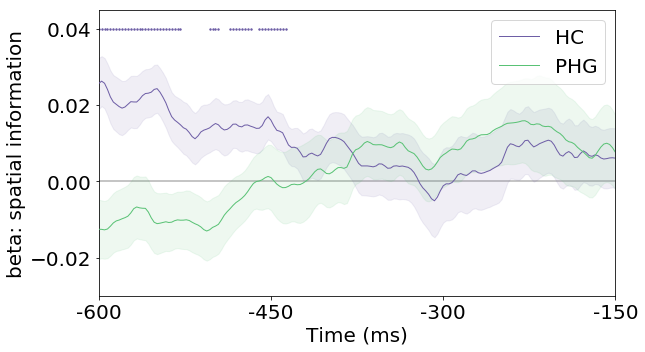

In [15]:
def inspect_similarity_timeresolved(outp, subjectList = subjectList):
    
    import matplotlib.patches as mpatches
    import statsmodels.api as sm
    import pandas as pd
    from matplotlib import gridspec
    import matplotlib.ticker as ticker
    from statistics import lrtest
    
    scratch_dir = '/scratch/nherweg/courier/01_ReactivatedSpatialContext/POW/'

    col_PHG = [89/255.,194/255.,117/255.]
    col_HC = [110/255.,94/255.,166/255.]
    
    f = open(scratch_dir+'Trialcount_exc.txt')
    exc = f.read().split('\n')
    
    params_PHG = []
    params_HC  = []
    sub_HC     = []
    sub_PHG    = []
    sub_w      = []
    
    prox_spatial    = []
    prox_temporal   = []
    prox_study_test = []
    time            = []
    similarity      = []
    sub_long        = []
    brain_region    = []
    
    for subi in subjectList:

        if subi+outp+'HC' not in exc:
            
            params_HC.append(np.array(np.load(scratch_dir+subi+outp+'HC.npz')['params'])[:,1])
            sub_HC.append(subi)
          
        if subi+outp+'PHG' not in exc:
            
            params_PHG.append(np.array(np.load(scratch_dir+subi+outp+'PHG.npz')['params'])[:,1])
            sub_PHG.append(subi)
  
    region = np.concatenate([['HC']*np.array(params_HC).shape[0]*np.array(params_HC).shape[1],['PHG']*np.array(params_PHG).shape[0]*np.array(params_PHG).shape[1]])
    params = np.concatenate([np.array(params_HC).reshape(-1),np.array(params_PHG).reshape(-1)])
    subs = np.concatenate([np.concatenate([[ii]*np.array(params_HC).shape[1] for ii in sub_HC]),np.concatenate([[ii]*np.array(params_PHG).shape[1] for ii in sub_PHG])])
    times = np.concatenate([np.arange(np.array(params_HC).shape[1]).tolist()*np.array(params_HC).shape[0],np.arange(np.array(params_PHG).shape[1]).tolist()*np.array(params_PHG).shape[0]])
    
    d = {'params':params, 'subs': subs,'region':region, 'times':times}
    df = pd.DataFrame(data=d)
 
    model = sm.MixedLM.from_formula("params ~ region+times", groups="subs", data=df)
    result = model.fit(reml = False,method = 'nm')
    llf_full = result.llf
    
    model = sm.MixedLM.from_formula("params ~ region", groups="subs", data=df)
    result = model.fit(reml = False,method = 'nm')
    llf_t = result.llf

    model = sm.MixedLM.from_formula("params ~ times", groups="subs", data=df)
    result = model.fit(reml = False,method = 'nm')
    llf_r = result.llf
    
    model = sm.MixedLM.from_formula("params ~ region+times+region*times", groups="subs", data=df)
    result = model.fit(reml = False,method = 'nm')
    llf_inter = result.llf
    print(result.summary())
    
    print('Times')
    lr, p = lrtest(llf_t, llf_full)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

    print('Region')
    lr, p = lrtest(llf_r, llf_full)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

    print('Interaction')
    lr, p = lrtest(llf_full, llf_inter)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

    ## Model for single brain region
    model = sm.MixedLM.from_formula("params ~ 1", groups="subs", data=df[df['region']=='HC'])
    result = model.fit(reml = False,method = 'nm')
    llf_inter_HC = result.llf
    
    model = sm.MixedLM.from_formula("params ~ times", groups="subs", data=df[df['region']=='HC'])
    result = model.fit(reml = False,method = 'nm')
    print(result.summary())
    llf_t_HC = result.llf
    
    print('Times in HC')
    lr, p = lrtest(llf_inter_HC, llf_t_HC)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))
    
    model = sm.MixedLM.from_formula("params ~ 1", groups="subs", data=df[df['region']=='PHG'])
    result = model.fit(reml = False,method = 'nm')
    llf_inter_PHG = result.llf
    
    model = sm.MixedLM.from_formula("params ~ times", groups="subs", data=df[df['region']=='PHG'])
    result = model.fit(reml = False,method = 'nm')
    print(result.summary())
    llf_t_PHG = result.llf
    
    print('Times in PHG')
    lr, p = lrtest(llf_inter_PHG, llf_t_PHG)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))
    
          
    print('Intercept only model')
    model = sm.MixedLM.from_formula("params ~ 1", groups="subs", data=df)
    result = model.fit(reml = False,method = 'nm')
    print(result.summary())
    
    params_PHG = np.array(params_PHG)
    params_HC = np.array(params_HC)

    fig1 = plt.figure(figsize = (14,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1]) 
    ax1  = fig1.add_subplot(gs[0])
    ax1.plot(np.mean(params_HC,axis = 0),color = col_HC, label = 'HC',linewidth = 1,zorder = 3)
    ax1.plot(np.mean(params_PHG,axis = 0),color = col_PHG, label = 'PHG',linewidth = 1,zorder = 3)
    for ii in range(params_HC.shape[1]):
        if scps.ttest_1samp(params_HC[:,ii],0)[1]<0.05:
            ax1.scatter(ii,0.04,color = col_HC, s = 2)
        elif scps.ttest_1samp(params_HC[:,ii],0)[1]<0.05:
            ax1.scatter(ii,0.038,color = col_PHG, s = 2)
    ax1.set_xlim(0,len(params_HC))      
    plt.fill_between(range(params_HC.shape[1]), np.mean(params_HC,axis = 0)-np.std(params_HC,axis = 0)/np.sqrt(params_HC.shape[0]), np.mean(params_HC,axis = 0)+np.std(params_HC,axis = 0)/np.sqrt(params_HC.shape[0]),color = col_HC, alpha = 0.1,zorder = 2)
    plt.fill_between(range(params_PHG.shape[1]), np.mean(params_PHG,axis = 0)-np.std(params_PHG,axis = 0)/np.sqrt(params_PHG.shape[0]), np.mean(params_PHG,axis = 0)+np.std(params_PHG,axis = 0)/np.sqrt(params_PHG.shape[0]),color = col_PHG, alpha = 0.1,zorder = 2)
    ax1.axhline(y = 0,c = [0.7,0.7,0.7],zorder = 1)
    plt.legend(loc='upper right', fontsize = 20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_ylabel('beta: spatial information', fontsize = 20)
    ax1.set_xlabel('Time (ms)', fontsize = 20)
    ax1.set_ylim((-.03,.045))
    plt.setp(ax1, xticks=range(0,params_PHG.shape[1]+2,params_PHG.shape[1]/3), xticklabels=range(-600,-149,150))#,yticks=range(0,len(POW_ENC.frequency),5),yticklabels = [int(v) for v in np.flipud(POW_ENC.frequency.data)[range(0,len(POW_ENC.frequency),5)]])
    plt.tight_layout()
    plt.show()
    
    #fig1.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/Spatial_information.eps')
    
inspect_similarity_timeresolved('_similarity_encoding_timeresolved_')

## Phase amplitude coupling by spatial clustering

In [ ]:
def phase_amplitude_coupling_cohen2008(varin, freqs = freqs, sessionList = sessionList, subjectList = subjectList):
    
    import numpy as np
    from os import path
    import sys
    sys.path.append(path.abspath('/home1/nherweg/00_projects/courier/02_scripts'))
    from subject import subject
    from scipy.signal import hilbert
    from copy import deepcopy
    from ptsa.data.timeseries import TimeSeries
    
    subi  = subject(index = varin[0], subjectList = subjectList).concatenate(False,sessionList).get_channel_info().define_rois()
    outp  = varin[1]
    
    scratch_dir = '/scratch/nherweg/courier/01_ReactivatedSpatialContext/'
    
    buffer_time = 2.0
    if not path.isfile(scratch_dir+'PHS/'+subi.name+outp+'_POW_L'):
        for s_ind,session_name in enumerate(subi.spath):

            power = TimeSeries.from_hdf(scratch_dir+'POW/'+subi.name+'_'+session_name[session_name.find('sess'):session_name.find('sess')+5]+'_POW_withBuffer_RET')
            power_low = TimeSeries.from_hdf(scratch_dir+'POW/'+subi.name+'_'+session_name[session_name.find('sess'):session_name.find('sess')+5]+'_POW_withBuffer_RET')
            phase = TimeSeries.from_hdf(scratch_dir+'PHS/'+subi.name+'_'+session_name[session_name.find('sess'):session_name.find('sess')+5]+'_PHS_RET')
            
            # Select freqs
            phase = phase[(phase.frequency>=freqs['theta'][0]) & (phase.frequency<=freqs['theta'][1]),:,:,:]

            #Z-score (important to remove DC for hilbert transform))
            trialM   = np.nanmean(power.data,axis = -1)
            trialSTD = np.nanstd(power.data,axis = -1, ddof = 1)

            power = power-np.broadcast_to(trialM[:,:,:,np.newaxis], power.shape)
            power = power/np.broadcast_to(trialSTD[:,:,:,np.newaxis], power.shape)
            
            #Z-score (important to remove DC for hilbert transform))
            trialM   = np.nanmean(power_low.data,axis = -1)
            trialSTD = np.nanstd(power_low.data,axis = -1, ddof = 1)

            power_low = power_low-np.broadcast_to(trialM[:,:,:,np.newaxis], power_low.shape)
            power_low = power_low/np.broadcast_to(trialSTD[:,:,:,np.newaxis], power_low.shape)

            if s_ind == 0:
                POW = deepcopy(power)
                POW_L = deepcopy(power_low)
                PHS = deepcopy(phase)
            else:
                POW = POW.append(power, dim = 'events')
                POW_L = POW_L.append(power_low, dim = 'events')
                PHS = PHS.append(phase, dim = 'events')
        
        # Select electrodes
        if 'REV' in outp:
            chanindc_HC  = [ind for ind, channeli in enumerate(POW.coords['channels']) if channeli.item() in subi.roi['PHG']]
            chanindc_PHG = [ind for ind, channeli in enumerate(PHS.coords['channels']) if channeli.item() in subi.roi['HC']]

        else:
            chanindc_PHG = [ind for ind, channeli in enumerate(POW.coords['channels']) if channeli.item() in subi.roi['PHG']]
            chanindc_HC  = [ind for ind, channeli in enumerate(PHS.coords['channels']) if channeli.item() in subi.roi['HC']]
     
        if len(chanindc_PHG) > 0 and len(chanindc_HC) > 0 and len(POW.events) > 7:
            
            # Remove buffer
            POW_noBuffer = POW.remove_buffer(duration = buffer_time)
            POW_L = POW_L.remove_buffer(duration = buffer_time)

            # Select freqs and electrodes
            PHS = PHS[:,chanindc_HC,:,:]
            POW_L = POW_L[(POW_L.frequency>=freqs['theta'][0]) & (POW_L.frequency<=freqs['theta'][1]),chanindc_HC,:,:].mean(dim = 'time')
            POW = POW[POW.frequency>freqs['theta'][1],chanindc_PHG,:,:]
            POW_noBuffer = POW_noBuffer[POW_noBuffer.frequency>freqs['theta'][1],chanindc_PHG,:,:]
            
            # Get PSD
            PSD_gamma       = np.fft.rfft(POW_noBuffer-np.broadcast_to(POW_noBuffer.mean(axis = -1).data[:,:,:,np.newaxis],POW_noBuffer.shape),axis = -1)
            freq_cont_gamma = np.fft.rfftfreq(POW_noBuffer.shape[-1]-1, d=1./POW_noBuffer['samplerate'].data)
            
            # Find max in PSD_gamma
            PSD_gamma = np.abs(PSD_gamma[:,:,:,(freq_cont_gamma > 3) & (freq_cont_gamma<=8)])**2
            nan_inds = np.where(np.isnan(PSD_gamma[:,:,:,0]))
            max_freqs = np.argmax(PSD_gamma,axis=3).astype(float).astype(str)
            max_freqs[nan_inds] = 'nan'
            
            # Map frequency content of PSD_gamma to frequency content of PHS and select freqs in PHS
            mapping = {str(np.float(ind)):np.float(np.abs(PHS.frequency.data-value).argmin()) for ind,value in enumerate(freq_cont_gamma[(freq_cont_gamma > 3) & (freq_cont_gamma<=8)])}
            mapping['nan'] = np.float('nan')
            max_freqs = np.vectorize(mapping.get)(max_freqs)
            
            # Get the phase of the gamma amplitude envelope
            z = hilbert(POW,axis = -1)
            PHS_gamma = np.angle(z)#np.arctan(z.imag/z.real)
            
            def phase_coherence(phase_h,phase_l,pow_l = None,permutation = False):

                # Calculate phase coherence
                si = np.empty((phase_h.shape[0],phase_h.shape[1],len(phase_l.channels),phase_h.shape[2]),dtype = complex)
                pow_out = np.empty((phase_h.shape[0],phase_h.shape[1],len(phase_l.channels),phase_h.shape[2]))
                for freqi in range(phase_h.shape[0]):
                    for eleci_PHG in range(phase_h.shape[1]):
                        for eventi in range(phase_h.shape[2]):
                            for eleci_HC in range(len(phase_l.channels)):
                                if np.isfinite(max_freqs[freqi,eleci_PHG,eventi]):
                                    if not permutation:
                                        pow_out[freqi,eleci_PHG,eleci_HC,eventi] = pow_l[int(max_freqs[freqi,eleci_PHG,eventi]),eleci_HC,eventi]
                                    si[freqi,eleci_PHG,eleci_HC,eventi] = np.mean(np.exp(1j*(phase_l.data[int(max_freqs[freqi,eleci_PHG,eventi]),eleci_HC,eventi,:]-phase_h[freqi,eleci_PHG,eventi,:])))
                                else: 
                                    if not permutation:
                                        pow_out[freqi,eleci_PHG,eleci_HC,eventi] = np.float('nan')
                                    si[freqi,eleci_PHG,eleci_HC,eventi] = np.float('nan')
                return si, pow_out

            # Remove buffer
            PHS_gamma_noBuffer = PHS_gamma[:,:,:,int(PHS.samplerate*buffer_time):PHS_gamma.shape[-1]-int(PHS.samplerate*buffer_time)]

            skip_min = PHS.samplerate.data/PHS.frequency.data[0]            
            skip_max = PHS.samplerate.data*buffer_time-1

            if not path.isfile('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/permutations_shift'+outp+'.npy'):
                raise ValueError('No permutation file found. Use code below outside of parallel loop to create.')
                skip_shift = np.concatenate([np.random.randint(-skip_max,high = -skip_min,size = 1000),np.random.randint(skip_min,high = skip_max,size = 1000)], axis = 0)
                np.save('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/permutations_shift'+outp+'.npy',skip_shift)
            
            skip_shift  = np.load('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/permutations_shift'+outp+'.npy')
            
            SI_vals = np.empty((PHS_gamma_noBuffer.shape[0],PHS_gamma_noBuffer.shape[1],len(PHS.channels),PHS_gamma_noBuffer.shape[2],2001),dtype = complex)
            SI_vals[:,:,:,:,0], POW_L_vals = phase_coherence(PHS_gamma_noBuffer,PHS, POW_L)
      
            for perm in range(2000):
                skip = skip_shift[perm]
                PHS_gamma_S = PHS_gamma[:,:,:,int(PHS.samplerate*buffer_time)+skip:PHS_gamma.shape[-1]-int(PHS.samplerate*buffer_time)+skip]
            
                SI_vals[:,:,:,:,perm+1],_ = phase_coherence(PHS_gamma_S,PHS,permutation = True)

            SI = TimeSeries(SI_vals,
                              dims=['frequency','channels_PHG','channels_HC','events','permutation'], 
                              coords={'frequency':POW.frequency,'channels_PHG':POW.channels.data, 'channels_HC':PHS.channels.data,'events': POW['events'],'permutation':range(2001),'samplerate':POW['samplerate']})
            
            POW_L = TimeSeries(POW_L_vals,
                              dims=['frequency','channels_PHG','channels_HC','events'], 
                              coords={'frequency':POW.frequency,'channels_PHG':POW.channels.data, 'channels_HC':PHS.channels.data,'events': POW['events'],'samplerate':POW['samplerate']})


            SI.to_hdf(scratch_dir+'PHS/'+subi.name+outp)
            POW_L.to_hdf(scratch_dir+'PHS/'+subi.name+outp+'_POW_L')
 
        else:
            f = open(scratch_dir+'POW/Trialcount_exc.txt','a')
            f.write(subi.name+'_PAC_PLV_RET'+'\n')
            f.close()
            #if no electrodes in PHG or HC and minimum trial criterion


with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=10, cores_per_job=1, extra_params={'mem':20}) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(phase_amplitude_coupling_cohen2008, [[ind,outi,methodi] for ind,outi,methodi in zip(range(len(subjectList)),['_PAC_PLV_RET' for subi in subjectList])])
with cluster_helper.cluster.cluster_view(scheduler="sge", queue="RAM.q", num_jobs=len(subjectList), cores_per_job=1, extra_params={'mem':20}) as view:   #Get a hold of some worker nodes, accessed via the view object.
    view.map(phase_amplitude_coupling_cohen2008, [[ind,outi,methodi] for ind,outi,methodi in zip(range(len(subjectList)),['_PAC_PLV_RET_REV' for subi in subjectList])])

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arctanh


('Number of electrodes with no shared ref', (92,))
('Number of electrodes with shared ref', (4,))


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:897: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["_group"] = kwargs["groups"]
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  si       
No. Observations:  2398     Method:              ML       
No. Groups:        14       Scale:               0.0133   
Min. group size:   8        Likelihood:          1701.8930
Max. group size:   604      Converged:           Yes      
Mean group size:   171.3                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.345    0.011 30.267 0.000  0.323  0.368
clustering       0.000    0.000  1.049 0.294 -0.000  0.000
tclustering      0.000    0.000  0.473 0.636 -0.000  0.000
pl               0.019    0.006  3.139 0.002  0.007  0.030
serialPos       -0.003    0.001 -4.346 0.000 -0.004 -0.002
outputPos       -0.000    0.001 -0.325 0.745 -0.002  0.002
channel_pair RE  0.003    0.004                           



/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Spatial, Frequency: beta
LR test, p value: 1.10, 0.2943
Temporal, Frequency: beta
LR test, p value: 0.22, 0.6364


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  si       
No. Observations:  2398     Method:              ML       
No. Groups:        14       Scale:               0.0076   
Min. group size:   8        Likelihood:          2345.4564
Max. group size:   604      Converged:           Yes      
Mean group size:   171.3                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.264    0.010 27.761 0.000  0.245  0.282
clustering       0.000    0.000  1.866 0.062 -0.000  0.000
tclustering      0.000    0.000  0.855 0.393 -0.000  0.000
pl               0.014    0.004  3.079 0.002  0.005  0.023
serialPos       -0.001    0.001 -1.872 0.061 -0.002  0.000
outputPos       -0.002    0.001 -2.242 0.025 -0.003 -0.000
channel_pair RE  0.003    0.006                           



/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Spatial, Frequency: gamma
LR test, p value: 3.48, 0.0620
Temporal, Frequency: gamma
LR test, p value: 0.73, 0.3928


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  si       
No. Observations:  2398     Method:              ML       
No. Groups:        14       Scale:               0.0059   
Min. group size:   8        Likelihood:          2645.0732
Max. group size:   604      Converged:           Yes      
Mean group size:   171.3                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.193    0.008 23.300 0.000  0.177  0.210
clustering       0.000    0.000  2.273 0.023  0.000  0.000
tclustering      0.000    0.000  1.221 0.222 -0.000  0.000
pl               0.008    0.004  2.172 0.030  0.001  0.016
serialPos       -0.001    0.000 -2.024 0.043 -0.002 -0.000
outputPos       -0.001    0.001 -2.058 0.040 -0.003 -0.000
channel_pair RE  0.002    0.005                           



/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Spatial, Frequency: hgamma
LR test, p value: 5.16, 0.0231
Temporal, Frequency: hgamma
LR test, p value: 1.49, 0.2222


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


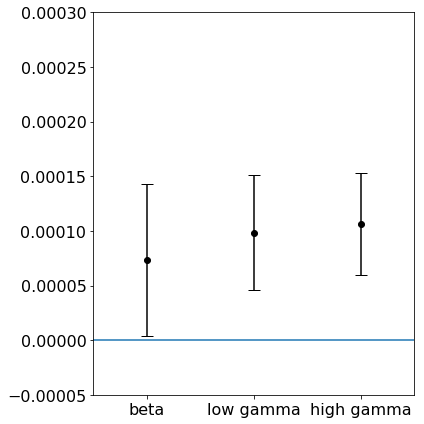

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       si       
No. Observations:        7194          Method:                   ML       
No. Groups:              14            Scale:                    0.0092   
Min. group size:         24            Likelihood:               6538.7359
Max. group size:         1812          Converged:                Yes      
Mean group size:         513.9                                            
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       0.332    0.008  42.986 0.000  0.317  0.347
frequency[T.gamma]             -0.066    0.005 -12.824 0.000 -0.076 -0.056
frequency[T.hgamma]            -0.131    0.005 -25.620 0.000 -0.141 -0.121
clustering                      0.000    0.

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Clustering x frequency
LR test, p value: 0.08, 0.9611


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   si       
No. Observations:     7194      Method:               ML       
No. Groups:           14        Scale:                0.0092   
Min. group size:      24        Likelihood:           6538.6962
Max. group size:      1812      Converged:            Yes      
Mean group size:      513.9                                    
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.332    0.007  45.377 0.000  0.318  0.346
frequency[T.gamma]  -0.066    0.003 -23.854 0.000 -0.071 -0.061
frequency[T.hgamma] -0.130    0.003 -47.106 0.000 -0.136 -0.125
clustering           0.000    0.000   2.588 0.010  0.000  0.000
tclustering          0.000    0.000   1.609 0.108 -0.000  0.000
pl                   0.012    0.003   4.129 0.000  0.

/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Spatial clustering
LR test, p value: 6.70, 0.0097
Temporal clustering
LR test, p value: 2.59, 0.1077


/home1/nherweg/anaconda2/envs/freshstart_rev/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


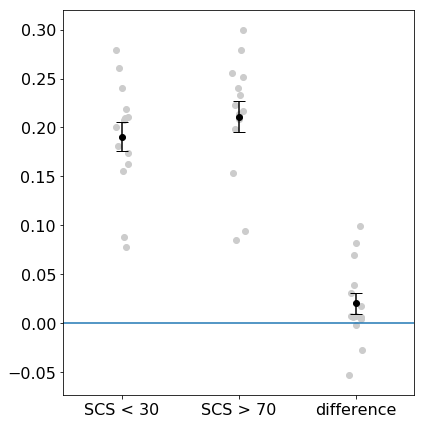

In [18]:
def inspect_PAC(inp,subjectList = subjectList):

    import statsmodels.api as sm
    import pandas as pd
    from statistics import lrtest
    
    scratch_dir = '/scratch/nherweg/courier/01_ReactivatedSpatialContext/'
    
    exc = open(scratch_dir+'POW/Trialcount_exc.txt','r').read().split('\n')
    
    SI = []
    PL = []
   
    sublist = []
    
    for ind,subi in enumerate(subjectList):
        
        if subi+'_PAC_PLV_RET' not in exc:
            sublist.append(subi)
            si = TimeSeries.from_hdf(scratch_dir+'PHS/'+subi+inp)#'_PAC_PLV_RET_REV'
            pl = TimeSeries.from_hdf(scratch_dir+'PHS/'+subi+inp+'_POW_L')#'_PAC_PLV_RET_REV_POW_L'
            si = np.arctanh(abs(si[:,:,:,:,0]))
            
            SI.append(si)
            PL.append(pl)
   
    # Create long data frame
    clustering   = []
    tclustering  = []
    trials       = []
    serialPos    = []
    outputPos    = []
    channels_HC  = []
    channels_PHG = []
    frequency    = []
    subject      = []
    data         = []
    data_pl      = []
  
    for s_ind,si in enumerate(SI):
        clustering.extend(si.events.data['postPerc'].tolist()*si.data.shape[0]*si.data.shape[1]*si.data.shape[2])
        tclustering.extend(si.events.data['postPerc_time'].tolist()*si.data.shape[0]*si.data.shape[1]*si.data.shape[2])
        serialPos.extend(si.events.data['serialPos'].tolist()*si.data.shape[0]*si.data.shape[1]*si.data.shape[2])
        outputPos.extend(si.events.data['outputPosition'].tolist()*si.data.shape[0]*si.data.shape[1]*si.data.shape[2])
        trials.extend(np.arange(len(si.events)).tolist()*si.data.shape[0]*si.data.shape[1]*si.data.shape[2])
        channels_HC.extend([item for sublist in [[ii]*si.shape[3] for ii in si.channels_HC.data] for item in sublist]*si.data.shape[0]*si.data.shape[1])
        channels_PHG.extend([item for sublist in [[ii]*si.shape[3]*si.shape[2] for ii in si.channels_PHG.data] for item in sublist]*si.data.shape[0])
        frequency.extend([item for sublist in [[int(round(ii))]*si.shape[3]*si.shape[2]*si.shape[1] for ii in si.frequency.data] for item in sublist])
        subject.extend([s_ind]*si.shape[0]*si.shape[1]*si.shape[2]*si.shape[3])
        data.extend(si.data.reshape(-1))
        data_pl.extend(PL[s_ind].data.reshape(-1))
    
    frequency = ['alpha' if ii <= 15 else 'beta' if ii <= 31 else 'gamma' if ii <=70 else 'hgamma' for ii in frequency]
    shared_ref = [True if np.any([cHi in cP.tolist() for cHi in cH]) else False for cH,cP in zip(channels_HC,channels_PHG) ]    
    channel_pair = [str(cH)+str(cP) for cH,cP in zip(channels_HC,channels_PHG)]

    print('Number of electrodes with no shared ref',np.unique(np.array(channel_pair)[np.array(shared_ref) == False]).shape)
    print('Number of electrodes with shared ref',np.unique(np.array(channel_pair)[np.array(shared_ref) == True]).shape)
    
    df = {'si':data,'pl':data_pl,'serialPos':serialPos,'outputPos':outputPos,'clustering':clustering,'tclustering':tclustering,'trials':trials,'shared_ref':shared_ref,'channel_pair':channel_pair,'frequency':frequency,'subject':subject}
    df = pd.DataFrame(data=df)
    df = df[(np.isfinite(df['si'])) & (df['shared_ref']==False) & (np.isfinite(df['clustering'])) & (df['frequency']!='alpha')]
    
    vcf = {"channel_pair": "0+C(channel_pair)"}

    # Average within frequency bands
    df = df.groupby(['frequency','subject','serialPos','outputPos','trials','channel_pair'],as_index = False).mean()
    
    # Stats within frequency band
    beta = []
    b_se = []
    avg_si_by_freq = []
    sem_si_by_freq = []
    for fi in np.unique(df['frequency']):
        
        model = sm.MixedLM.from_formula("si ~ clustering + tclustering + pl + serialPos + outputPos ", groups="subject", vc_formula=vcf,  data=df[df['frequency'] == fi]) 
        result = model.fit(reml = False,method = 'nm')
        print(result.summary())
        llf_fu = result.llf
        beta.append(result.fe_params['clustering'])
        b_se.append(result.bse_fe['clustering'])
        
        model = sm.MixedLM.from_formula("si ~  tclustering + pl + serialPos + outputPos ", groups="subject", vc_formula=vcf,  data=df[df['frequency'] == fi]) 
        result = model.fit(reml = False,method = 'nm')
        llf_reduced = result.llf
        
        model = sm.MixedLM.from_formula("si ~  clustering + pl + serialPos + outputPos ", groups="subject", vc_formula=vcf,  data=df[df['frequency'] == fi]) 
        result = model.fit(reml = False,method = 'nm')
        llf_reduced_temporal = result.llf
        
        print('Spatial, Frequency: '+str(fi))
        lr, p = lrtest(llf_reduced, llf_fu)
        print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))
        
        print('Temporal, Frequency: '+str(fi))
        lr, p = lrtest(llf_reduced_temporal, llf_fu)
        print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))
        
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.errorbar(np.arange(len(np.unique(df['frequency']))),beta,yerr = b_se, fmt = 'o', color = 'k', capsize= 6)
    ax.axhline (y = 0)
    ax.set_xlim([-0.5,2.5])
    ax.set_ylim([-0.00005,0.0003])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.xticks(range(0,3), ['beta', 'low gamma', 'high gamma'])
    plt.tight_layout()
    plt.show()
    #fig.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/PAC_param_estimates_by_freq_band.eps')
    
    # Stats across frequency bands
    model = sm.MixedLM.from_formula("si ~ clustering + tclustering + frequency + pl + serialPos + outputPos + clustering:frequency", groups="subject",vc_formula=vcf,  data=df) 
    result = model.fit(reml = False,method = 'nm')
    print(result.summary())
    llf_cf = result.llf

    model = sm.MixedLM.from_formula("si ~ clustering + tclustering + frequency + pl + serialPos + outputPos", groups="subject",vc_formula=vcf,  data=df) 
    result = model.fit(reml = False,method = 'nm')
    llf_full = result.llf
    
    print('Clustering x frequency')
    lr, p = lrtest(llf_full, llf_cf,df =2)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))

    model = sm.MixedLM.from_formula("si ~ clustering + tclustering + frequency + pl + serialPos + outputPos ", groups="subject", vc_formula=vcf,  data=df) #
    result = model.fit(reml = False,method = 'nm')
    llf_full = result.llf
    print(result.summary())

    model = sm.MixedLM.from_formula("si ~ tclustering + frequency + pl + serialPos + outputPos ", groups="subject", vc_formula=vcf,  data=df) 
    result = model.fit(reml = False,method = 'nm')
    llf_c = result.llf
    
    model = sm.MixedLM.from_formula("si ~ clustering + frequency + pl + serialPos + outputPos ", groups="subject", vc_formula=vcf,  data=df) 
    result = model.fit(reml = False,method = 'nm')
    llf_t = result.llf
    
    print('Spatial clustering')
    lr, p = lrtest(llf_c, llf_full)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))
    
    print('Temporal clustering')
    lr, p = lrtest(llf_t, llf_full)
    print('LR test, p value: {:.2f}, {:.4f}'.format(lr, p))
 
    # Average over trials and channels to visualize effect in the high gamma band
    df1 = df[(df['clustering']<30) & (df['frequency']=='hgamma')].groupby(['subject'], as_index=False).mean()
    df2 = df[(df['clustering']>70) & (df['frequency']=='hgamma')].groupby(['subject'], as_index=False).mean()

    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.scatter(np.zeros(len(df1))+np.random.uniform(-0.06,0.06, size = len(df1)),df1['si'], color = [0.8,0.8,0.8])
    ax.scatter(np.zeros(len(df2))+np.random.uniform(-0.06,0.06, size = len(df1))+1,df2['si'], color = [0.8,0.8,0.8])
    ax.scatter(np.zeros(len(df2))+np.random.uniform(-0.06,0.06, size = len(df1))+2,df2['si']-df1['si'], color = [0.8,0.8,0.8])
    ax.errorbar(0,np.mean(df1['si']),np.std(df1['si'])/np.sqrt(len(df1['si'])),color = 'k', capsize = 6,fmt = 'o')
    ax.errorbar(1,np.mean(df2['si']),np.std(df2['si'])/np.sqrt(len(df2['si'])),color = 'k', capsize = 6,fmt = 'o')
    ax.errorbar(2,np.mean(df2['si']-df1['si']),np.std(df2['si']-df1['si'])/np.sqrt(len(df1['si'])),color = 'k', capsize = 6,fmt = 'o')
    ax.axhline(y = 0)
    ax.set_xlim([-0.5,2.5])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.xticks(range(0,3), ['SCS < 30', 'SCS > 70', 'difference'])
    plt.tight_layout()
    plt.show()
    #fig.savefig('/home1/nherweg/00_projects/courier/01_analyses/01_ReactivatedSpatialContext/figures/PAC_by_SCS_hgamma.eps')

inspect_PAC('_PAC_PLV_RET')    